In [1]:
import warnings
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import tqdm
from decimal import Decimal

In [2]:
clin = pd.read_csv('clin.csv')

In [9]:
len(np.unique(clin[clin["responder"]=="Non-responder"]["patient"]))

26

In [10]:
mel = sc.read_h5ad("adata_nr_latest.h5")

In [14]:
sc.tl.rank_genes_groups(mel, groupby='echidna_status', method='wilcoxon')

In [16]:
deg = sc.get.rank_genes_groups_df(mel, group="shrinking").sort_values(by="logfoldchanges",ascending=True)

In [18]:
deg.index = deg["names"]
deg.loc["ADAR"]

names                  ADAR
scores           -38.523163
logfoldchanges    -0.562796
pvals                   0.0
pvals_adj               0.0
Name: ADAR, dtype: object

In [3]:
mel.X = mel.layers["counts"]

In [4]:
PATH = "unfiltered_etas/"

import os
all_delta_eta = pd.DataFrame()
for patient in os.listdir(PATH):
    if "delta_eta" in patient:
        #print(patient)
        eta = pd.read_csv(PATH+patient, index_col=0)
        all_delta_eta = pd.concat((all_delta_eta, eta),axis=1)

mt_patients = np.unique([i.split("_")[0] for i in all_delta_eta.columns])

PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        #print(patient)
        eta = pd.read_csv(PATH+patient+"/delta_eta.csv", index_col=0)
        #eta.columns = [patient+"_"+str(i) for i in eta.columns]
        all_delta_eta = pd.concat((all_delta_eta, eta),axis=1)

all_delta_eta = all_delta_eta.dropna()

In [9]:
all_ads = []
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        print(patient)
        X = sc.read_h5ad(PATH+patient+"/"+"X.h5ad")
        X.X = X.layers["counts"]
        all_ads.append(X)

F18_post
F06_post1_pre2
F22_post
F20_post1_pre2
F23_post
F28_post1_pre2
F08_post
F27_post1_pre2
F09_post
R294_on
F30_post
F26_post
F04_pre
F05_pre
F29_post1_pre2
F07_post1_pre2
F15_pre
F31_post
R334_pre
R329_on
F17_post
R328_on
R354_pre


In [10]:
sts = sc.concat(all_ads)

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/merge.py:1279: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
adata = sc.concat([sts, mel])

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata.obs_names_make_unique()

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['TTCCCAGGTGGTCTCG-1-1', 'GTGTTAGTCTTGTTTG-1-1', 'CAGAATCCAGCCTGTG-1-1', 'TTCGAAGCAGTGACAG-1-1', 'TCAGATGTCACGACTA-1-1']
  warnings.warn(


In [13]:
adata.layers["counts"] = adata.X
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs['original_total_counts'] = adata.obs['total_counts']

# log10 original library size
adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])

# Normalize by median library size
med = np.median(adata.obs['original_total_counts'])
sc.pp.normalize_total(adata, target_sum = med)
sc.pp.log1p(adata)

In [14]:
clin = pd.read_csv('clin.csv')
obs = adata.obs
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["responder"])[0])

adata.obs["responder"] = add

sc.tl.rank_genes_groups(adata, groupby="responder", method='wilcoxon')
deg = sc.get.rank_genes_groups_df(adata, group="Responder").sort_values(by="logfoldchanges",ascending=True)



clin = clin.loc[:,['patient','responder']]
clin.index = clin.patient
clin = clin.drop_duplicates()

gr = list(clin.loc[clin.responder=='Responder'].index) 
sh = list(clin.loc[clin.responder=='Non-responder'].index) 


deg = deg[deg["pvals_adj"]<.05]
deg = deg[deg["logfoldchanges"]>0]
deg.index = deg["names"]

deg_nr = sc.get.rank_genes_groups_df(adata, group="Non-responder").sort_values(by="logfoldchanges",ascending=True)
deg_nr = deg_nr[deg_nr["pvals_adj"]<.05]
deg_nr = deg_nr[deg_nr["logfoldchanges"]>0]
deg_nr.index = deg_nr["names"]

deg_both = list(deg.index) + list(deg_nr.index)


In [15]:
clin = pd.read_csv('clin.csv')
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["Gender"])[0])

adata.obs["gender"] = add

In [16]:
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["treated"])[0])

adata.obs["treated"] = add

In [52]:
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["combination"])[0])

adata.obs["combination"] = add

In [18]:
clin = pd.read_csv('clin.csv')
obs = adata.obs

add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["treat_resp"])[0])

adata.obs["treat_resp"] = add

In [19]:
adata.obs["treat_resp_gender"] = np.asarray(obs["treat_resp"])+np.asarray(["_" for i in range(adata.shape[0])])+np.asarray([str(i) for i in obs["gender"]])


In [20]:
obs = adata.obs
obs["pt_cluster"] = np.asarray(obs["patient"])+np.asarray(["_" for i in range(adata.shape[0])])+np.asarray([str(i) for i in obs["leiden"]])

exp_norm = pd.DataFrame()
df = adata.to_df()
for cl in np.unique(obs["pt_cluster"]):
    exp_norm = pd.concat((exp_norm, pd.DataFrame(df.loc[obs[obs["pt_cluster"]==cl].index].mean(axis=0),columns=[cl])),axis=1)

poggle = exp_norm

In [188]:
clin = clin.loc[:,['patient','responder']]
clin.index = clin.patient
clin = clin.drop_duplicates()

gr = list(clin.loc[clin.responder=='Responder'].index) 
sh = list(clin.loc[clin.responder=='Non-responder'].index) 

In [189]:

df = poggle.T
df.index.name = 'clusters'
df['patient_cluster'] = df.index
df['patient'] = [i.split("_")[0] for i in df['patient_cluster']]
df['responder'] = [clin.loc[i]["responder"] for i in df["patient"]]
#df['cluster'] = df['patient_cluster'].apply(lambda x:x.split('_')[-1])
df.head()

genes        ISG15      AGRN  C1orf159  AL390719.3   TNFRSF4      SDF4  \
clusters                                                                 
F01_0     0.000000  0.063349  0.076115    0.004213  0.000308  0.114829   
F01_1     0.000000  0.092585  0.080570    0.005883  0.000000  0.133589   
F01_2     0.004001  0.076680  0.063557    0.001262  0.000739  0.206607   
F01_3     0.000862  0.075935  0.071282    0.003488  0.000708  0.144182   
F01_4     0.003543  0.062411  0.049367    0.000000  0.000724  0.116339   

genes      B3GALT6  C1QTNF12    UBE2J2  LINC01786  ...  CXorf40B  LINC00894  \
clusters                                           ...                        
F01_0     0.021357  0.000313  0.036750   0.005374  ...  0.066755   0.283673   
F01_1     0.026705  0.001040  0.042016   0.005756  ...  0.067658   0.321169   
F01_2     0.037255  0.000497  0.051424   0.003942  ...  0.105573   0.263149   
F01_3     0.025002  0.000843  0.040172   0.003002  ...  0.082728   0.299832   
F01_4     0.022834  0.001531  0.033103   0.002855  ...  0.050743   0.195501   

genes       MAMLD1      MTM1     MTMR1    CD99L2     HMGB3  patient_cluster  \
clusters                                                                      
F01_0     0.400011  0.174543  0.221855  0.188048  0.000241            F01_0   
F01_1     0.427355  0.174296  0.218881  0.228333  0.002146            F01_1   
F01_2     0.390524  0.164021  0.240460  0.251726  0.006729            F01_2   
F01_3     0.419769  0.158455  0.229099  0.214859  0.001108            F01_3   
F01_4     0.301354  0.113300  0.165751  0.176847  0.004364            F01_4   

genes     patient      responder  
clusters                          
F01_0         F01  Non-responder  
F01_1         F01  Non-responder  
F01_2         F01  Non-responder  
F01_3         F01  Non-responder  
F01_4         F01  Non-responder  

[5 rows x 17171 columns]

In [190]:
def adjust_clusters(group, median_clusters=10):
    if len(group) > median_clusters:
        return group.sample(median_clusters, random_state=1)
    else:
        return group.sample(median_clusters, replace=True, random_state=1)

adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)

adjusted_df = df.reset_index(drop=True)

df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')
df_features.head()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/426435309.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/426435309.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')


genes     ISG15      AGRN  C1orf159  AL390719.3   TNFRSF4      SDF4   B3GALT6  \
0      0.000000  0.063349  0.076115    0.004213  0.000308  0.114829  0.021357   
1      0.000000  0.092585  0.080570    0.005883  0.000000  0.133589  0.026705   
2      0.004001  0.076680  0.063557    0.001262  0.000739  0.206607  0.037255   
3      0.000862  0.075935  0.071282    0.003488  0.000708  0.144182  0.025002   
4      0.003543  0.062411  0.049367    0.000000  0.000724  0.116339  0.022834   

genes  C1QTNF12    UBE2J2  LINC01786  ...  LINC00893  CXorf40A  TMEM185A  \
0      0.000313  0.036750   0.005374  ...   0.139117  0.030765  0.151544   
1      0.001040  0.042016   0.005756  ...   0.132243  0.034191  0.163791   
2      0.000497  0.051424   0.003942  ...   0.112729  0.054722  0.163198   
3      0.000843  0.040172   0.003002  ...   0.138915  0.030147  0.157924   
4      0.001531  0.033103   0.002855  ...   0.089294  0.029018  0.124376   

genes  CXorf40B  LINC00894    MAMLD1      MTM1     MTMR1    CD99L2     HMGB3  
0      0.066755   0.283673  0.400011  0.174543  0.221855  0.188048  0.000241  
1      0.067658   0.321169  0.427355  0.174296  0.218881  0.228333  0.002146  
2      0.105573   0.263149  0.390524  0.164021  0.240460  0.251726  0.006729  
3      0.082728   0.299832  0.419769  0.158455  0.229099  0.214859  0.001108  
4      0.050743   0.195501  0.301354  0.113300  0.165751  0.176847  0.004364  

[5 rows x 17168 columns]

In [191]:
from statsmodels.stats.multitest import multipletests

def permutation_test(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels).abs()
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels).abs()
        permuted_stats[i, :] = permuted_stat.values

    # Calculate p-values
    p_values = (np.sum(permuted_stats >= observed_stats.values, axis=0) + 1) / (num_permutations + 1)
    
    return pd.Series(p_values, index=df.columns)

def fdr_correction(p_values, alpha=0.05):
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)

In [192]:
# positive = enriched in label_1, negative = enriched in label_0
def permutation_test_signed(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels)
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels)
        permuted_stats[i, :] = permuted_stat.values

    # Calculate two-sided p-values
    p_values = np.mean(np.abs(permuted_stats) >= np.abs(observed_stats.values), axis=0)
    
    # Create a DataFrame with test statistics and p-values
    results_df = pd.DataFrame({
        'test_statistic': observed_stats,
        'p_value': p_values
    }, index=df.columns)
    
    return results_df

In [193]:
res = permutation_test_signed(df_features, labels=adjusted_df['responder'], label_0="Responder", label_1="Non-responder", num_permutations=1000) # ties after 10K permutations
res

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 152.85it/s]


test_statistic  p_value
genes                              
ISG15             0.015482    0.119
AGRN             -0.030726    0.028
C1orf159         -0.000520    0.932
AL390719.3        0.001045    0.052
TNFRSF4          -0.005117    0.003
...                    ...      ...
MAMLD1            0.009430    0.662
MTM1              0.003599    0.776
MTMR1             0.000054    0.996
CD99L2            0.019695    0.081
HMGB3             0.002925    0.555

[17168 rows x 2 columns]

In [194]:
# pval_corrected = fdr_correction(pval, alpha=0.05)
res['p_value_adj'] = fdr_correction(res['p_value'], alpha=0.05)

res = res[res["p_value_adj"]<.05]

res_r = res[res['test_statistic']>0]
#res_r = res_r.loc[list(np.intersect1d(deg_nr.index, res_r.index))]
res_r = res_r.sort_values(by='test_statistic', ascending=False)

res_nr = res[res['test_statistic']<0]
#res_nr = res_nr.loc[list(np.intersect1d(deg.index, res_nr.index))]
res_nr = res_nr.sort_values(by='test_statistic', ascending=True)

In [71]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds

In [72]:
chr_lines, chr_list, genes = eta_no_bin(all_delta_eta)

In [67]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths
def plot_eta_deg(cat, genes, bw_adjust=.2, prominence=.4, save=None):
    sns.set_theme(style="white")
    
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=12)
    ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)
    ax3 = plt.subplot2grid((23,22), (3,0), colspan=1, rowspan=12,sharey = ax1)
    
    smooth = scipy.ndimage.gaussian_filter1d(all_delta_eta.dropna().T.loc[cl_r[cl_r[0]==cat].index], sigma=5, radius=50, axis=1)
    sns.heatmap(smooth, cmap='coolwarm', vmin=-2, vmax=2, ax=ax1, cbar=False)

    # Rasterize the heatmap (which is a QuadMesh object)
    for artist in ax1.collections:
        artist.set_rasterized(True)
    
    ticklines = []
    for i in range(len(chr_lines)):
        ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
        if i==0:
            ticklines.append(chr_lines[i]-.5*chr_lines[0])
            #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
        else:
            ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
            #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    ax1.set_xticks(ticklines, labels=chr_list, rotation=45)

    #for i in ['CCL28', 'NECTIN2', 'VEGFA']:
    #    ax1.axvline(x=list(all_delta_eta.dropna().index).index(i), color='teal', linewidth=1)
                    
    plot_degs = np.intersect1d(genes, all_delta_eta.dropna().index)
    draw_lines = [list(all_delta_eta.dropna().index).index(i) for i in plot_degs]
    
    #sns.kdeplot(draw_lines, bw_adjust=.1, ax=ax2, fill=True, color="pink")

    density = []
    for gene in genes:
        density.append(list(all_delta_eta.index).index(gene))
    #get max height of histogram bars
    counts, bin_edges, patches = plt.hist(density, bins=400)
    ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=bw_adjust), ax=ax2)
    # Extract KDE data
    kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
    kde_x = kde_line.get_xdata()
    kde_y = kde_line.get_ydata()
    
    #plt.clf()   
    
    #plt.plot(kde_x, kde_y)
    ax2.fill_between(kde_x, 0, kde_y, color='lightgrey')

    
    # Find peaks
    peaks, _ = find_peaks(kde_y, prominence=prominence)
    
    # Find peak widths
    results_full = peak_widths(kde_y, peaks, rel_height=0.5)  # Width at half prominence
    
    
    # Interpolated x-coordinates for the widths
    left_coords = results_full[2]
    right_coords = results_full[3]
    
    # Convert interpolated coordinates to indices
    left_indices = np.round(left_coords).astype(int)
    right_indices = np.round(right_coords).astype(int)

    #figure out which peaks correspond to amps
    hotspot_inds = []
    for i in range(len(left_coords)):
        #print(smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean())
        if smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
            hotspot_inds.append(i)
            
    peaks = peaks[hotspot_inds]
    left_indices = left_indices[hotspot_inds]
    right_indices = right_indices[hotspot_inds]
    

    for i in range(len(left_indices)):
        ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')
    ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
    ax2.set_yticks([])
    ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)  # Remove left spine
    ax2.spines["bottom"].set_visible(False)
    ax2.set_ylabel(None)
    
    treat_bar = list(cl_treat.loc[cl_r[cl_r[0]==cat].index][0]) #labels for treatment
    pat_bar = [i.split("_")[0] for i in cl_r[cl_r[0]==cat].index] #labels for patients
    
    pal = {
    'F01': '#8B5CF6',  # Purple
    'F02': '#EC4899',  # Pink
    'F03': '#14B8A6',  # Teal
    'F04': '#F97316',  # Orange
    'F05': '#9333EA',  # Dark Purple
    'F06': '#DB2777',  # Dark Pink
    'F07': '#0D9488',  # Deep Teal
    'F08': '#EA580C',  # Deep Orange
    'F09': '#7C3AED',  # Violet
    'F12': '#BE185D',  # Magenta
    'F15': '#0891B2',  # Cyan-Teal
    'F16': '#C2410C',  # Burnt Orange
    'F17': '#A855F7',  # Medium Purple
    'F18': '#F43F5E',  # Bright Red-Pink
    'F20': '#10B981',  # Green-Teal
    'F22': '#D97706',  # Gold-Orange
    'F23': '#6D28D9',  # Rich Indigo
    'F26': '#F87171',  # Coral Red
    'F27': '#34D399',  # Soft Green
    'F28': '#F59E0B',  # Golden Yellow
    'F29': '#6366F1',  # Blue-Purple
    'F30': '#EF4444',  # Bright Red
    'F31': '#22C55E',  # Bright Green
    'R294': '#4C1D95',  # Deep Indigo
    'R310': '#DB2777',  # Deep Pink
    'R319': '#0EA5E9',  # Bright Cyan
    'R328': '#FACC15',  # Vibrant Yellow
    'R329': '#9333EA',  # Dark Purple
    'R334': '#16A34A',  # Emerald Green
    'R354': '#E11D48',  # Deep Rose
    }
    ax3.scatter([2 for i in range(smooth.shape[0])],np.arange(smooth.shape[0])+.5, c=[pal[i] for i in pat_bar], marker='s', s=60)
    
    pal = {"Treated":"pink","Untreated":"teal"}
    ax3.scatter([1 for i in range(smooth.shape[0])],np.arange(smooth.shape[0])+.5, c=[pal[i] for i in treat_bar], marker='s', s=60)
    
    ax3.set_xlim([0,3])
    ax3.set_yticks([])
    ax3.set_xticks([1,2],["status","patient"], rotation=90)
    
    ax3.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["left"].set_visible(False)  # Remove left spine
    ax3.spines["bottom"].set_visible(False)
    
    ax2.set_title(cat)
    if save!=None:
        plt.savefig(save)
        
    return np.round(kde_x[left_indices]).astype(int), np.round(kde_x[right_indices]).astype(int)

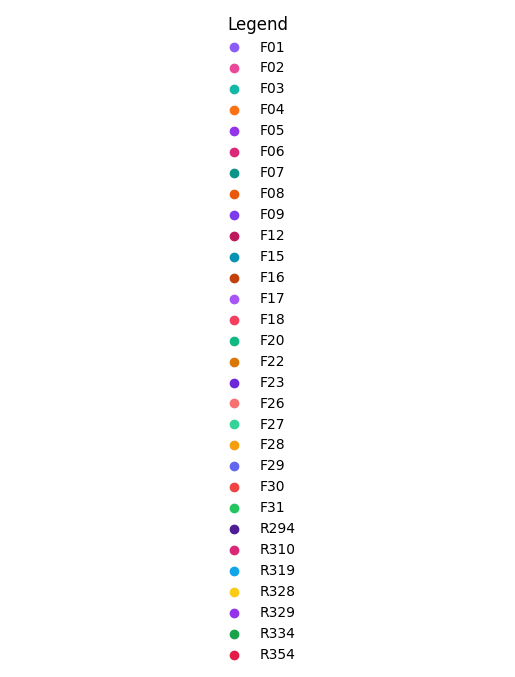

In [27]:
pal = {
'F01': '#8B5CF6',  # Purple
'F02': '#EC4899',  # Pink
'F03': '#14B8A6',  # Teal
'F04': '#F97316',  # Orange
'F05': '#9333EA',  # Dark Purple
'F06': '#DB2777',  # Dark Pink
'F07': '#0D9488',  # Deep Teal
'F08': '#EA580C',  # Deep Orange
'F09': '#7C3AED',  # Violet
'F12': '#BE185D',  # Magenta
'F15': '#0891B2',  # Cyan-Teal
'F16': '#C2410C',  # Burnt Orange
'F17': '#A855F7',  # Medium Purple
'F18': '#F43F5E',  # Bright Red-Pink
'F20': '#10B981',  # Green-Teal
'F22': '#D97706',  # Gold-Orange
'F23': '#6D28D9',  # Rich Indigo
'F26': '#F87171',  # Coral Red
'F27': '#34D399',  # Soft Green
'F28': '#F59E0B',  # Golden Yellow
'F29': '#6366F1',  # Blue-Purple
'F30': '#EF4444',  # Bright Red
'F31': '#22C55E',  # Bright Green
'R294': '#4C1D95',  # Deep Indigo
'R310': '#DB2777',  # Deep Pink
'R319': '#0EA5E9',  # Bright Cyan
'R328': '#FACC15',  # Vibrant Yellow
'R329': '#9333EA',  # Dark Purple
'R334': '#16A34A',  # Emerald Green
'R354': '#E11D48',  # Deep Rose
}
for i, (label, color) in enumerate(pal.items()):
    plt.scatter([], [], color=color, label=label)
    
plt.legend(title="Legend", loc='center', frameon=False, ncol=1, fontsize=10, title_fontsize=12)
plt.axis('off')
plt.savefig("mel_figures/figure_3_new/pt_legend.pdf", bbox_inches='tight')

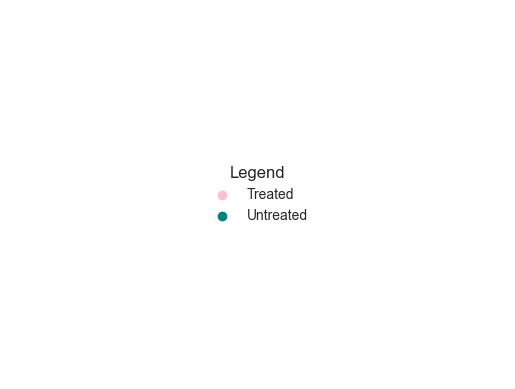

In [1468]:
pal = {"Treated":"pink","Untreated":"teal"}
for i, (label, color) in enumerate(pal.items()):
    plt.scatter([], [], color=color, label=label)
plt.legend(title="Legend", loc='center', frameon=False, ncol=1, fontsize=10, title_fontsize=12)
plt.axis('off')
plt.savefig("mel_figures/figure_3_new/treat_legend.pdf", bbox_inches='tight')

In [21]:
clin = pd.read_csv('clin.csv')
clin.index = clin["sample"]
clin = clin.drop_duplicates()

import os
PATH = "hmm_all_pt/"
cl_treat = pd.DataFrame()
for patient in os.listdir(PATH):
    if "_" not in patient:
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_treat[patient+"_"+str(cl)] = [clin.loc[sampl]["treated"]]
cl_treat = cl_treat.T

PATH = "hmm_all_pt/"
cl_r = pd.DataFrame()
for patient in os.listdir(PATH):
    if "_" not in patient:
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_r[patient+"_"+str(cl)] = [clin.loc[sampl]["responder"]]
cl_r = cl_r.T

In [22]:
obs["leiden"] = [str(i) for i in obs["leiden"]]

In [23]:
clin = pd.read_csv('clin.csv')
clin.index = clin["sample"]
clin = clin.drop_duplicates()

cl_treat = cl_treat.T
import os
PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        X = sc.read_h5ad(PATH+patient+"/X.h5ad")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_treat[patient+"_"+str(cl)] = [clin.loc[sampl]["treated"]]
cl_treat = cl_treat.T

cl_r = cl_r.T
PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        X = sc.read_h5ad(PATH+patient+"/X.h5ad")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_r[patient+"_"+str(cl)] = [clin.loc[sampl]["responder"]]
cl_r = cl_r.T

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2136874967.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_treat[patient+"_"+str(cl)] = [clin.loc[sampl]["treated"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2136874967.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_treat[patient+"_"+str(cl)] = [clin.loc[sampl]["treated"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2136874967.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [24]:
PATH = "hmm_all_pt/"
cl_g = pd.DataFrame()
for patient in os.listdir(PATH):
    if "_" not in patient:
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_g[patient+"_"+str(cl)] = [clin.loc[sampl]["Gender"]]
PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        X = sc.read_h5ad(PATH+patient+"/X.h5ad")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_g[patient+"_"+str(cl)] = [clin.loc[sampl]["Gender"]]
cl_g = cl_g.T

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2220966552.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_g[patient+"_"+str(cl)] = [clin.loc[sampl]["Gender"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2220966552.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_g[patient+"_"+str(cl)] = [clin.loc[sampl]["Gender"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2220966552.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

In [25]:
cl_rt = pd.DataFrame(cl_treat.loc[cl_r.index][0]+"_"+cl_r[0])

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_22585/4174732111.py:73: RuntimeWarning: Mean of empty slice.
  if smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


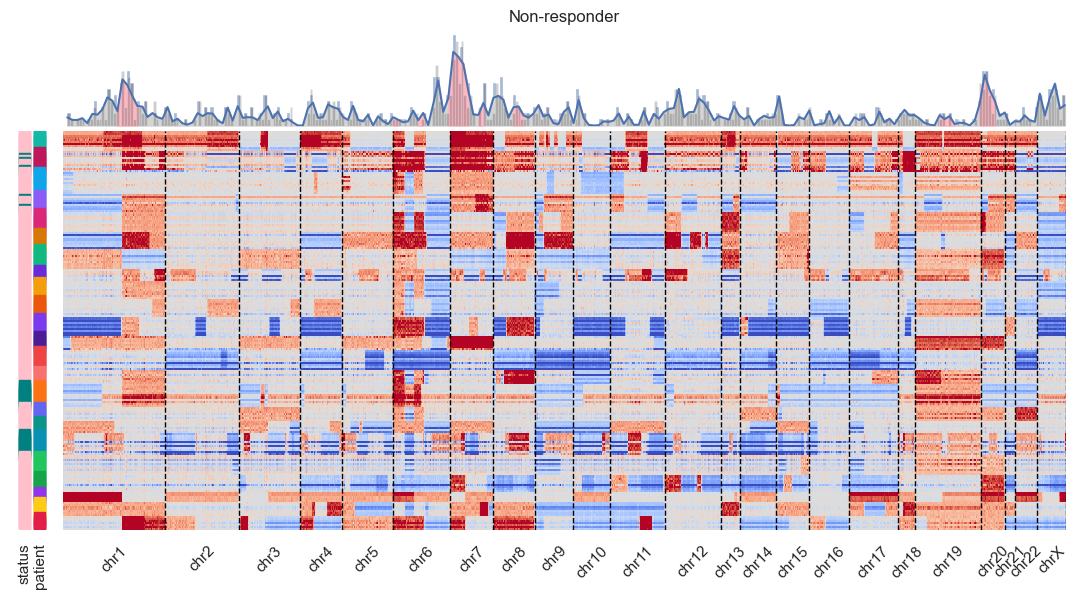

In [80]:
left, right = plot_eta_deg("Non-responder",res_r.index, bw_adjust=.02, prominence=.6)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/4174732111.py:73: RuntimeWarning: Mean of empty slice.
  if smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


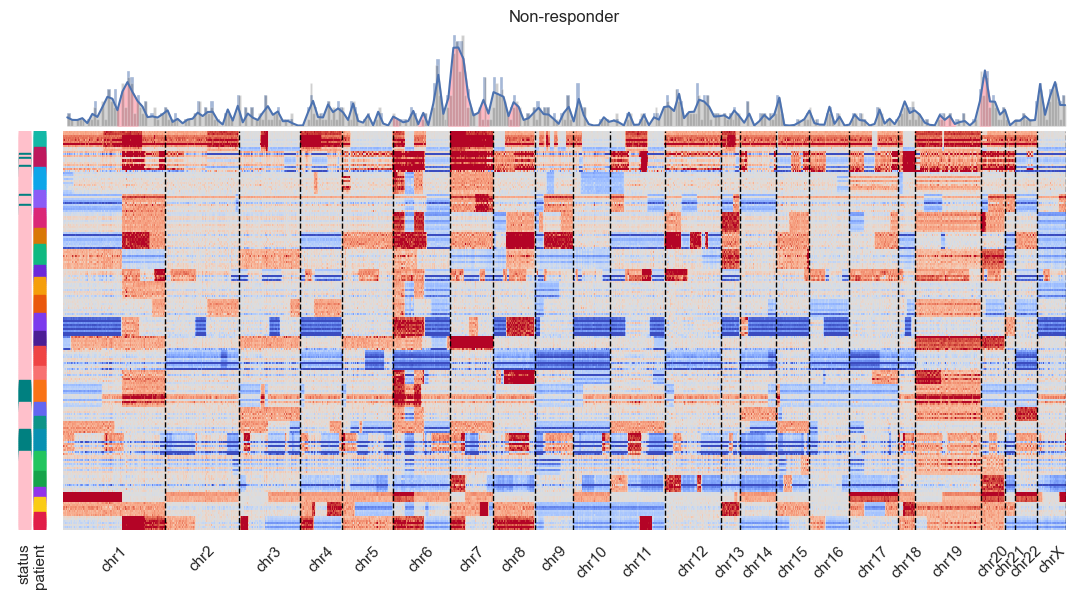

In [1393]:
left, right = plot_eta_deg("Non-responder",res_r.index, bw_adjust=.02, prominence=.6, 
                           save="mel_figures/figure_3_new/Fig3_NRs_heatmap_all.pdf")

In [81]:
hotspot_nr = []
for i in range(len(left)):
    print(np.intersect1d(all_delta_eta.index[left[i]:right[i]], res_r.index))
    hotspot_nr += list(np.intersect1d(all_delta_eta.index[left[i]:right[i]], res_r.index))

['ADAR' 'ANP32E' 'ARHGEF2' 'ASH1L' 'C1orf61' 'DAP3' 'DCST2' 'EFNA1'
 'FLAD1' 'GATAD2B' 'HAX1' 'MEX3A' 'MRPS21' 'NME7' 'PHGDH' 'PIP5K1A'
 'PLEKHO1' 'POU2F1' 'PSMD4' 'RPRD2' 'SCNM1' 'SEMA6C' 'SETDB1' 'SHE'
 'SPTA1' 'TARS2' 'TDRD10' 'UBQLN4' 'UCK2' 'VPS72' 'YY1AP1']
['SYCP2L']
['RCAN2']
['AC005165.1' 'AC007036.1' 'AC007130.1' 'AC007255.1' 'AC011290.1'
 'AC072054.1' 'AC073332.1' 'AC091729.3' 'AHR' 'AL135910.1' 'ANKMY2'
 'AUTS2' 'BBS9' 'BX322234.1' 'BZW2' 'C7orf31' 'CAMK2B' 'CCM2' 'CDK13'
 'CDK14' 'COA1' 'CRPPA' 'DDX56' 'EGFR' 'FAM126A' 'GARS' 'GLCCI1' 'HIBADH'
 'HOTAIRM1' 'KLHL7' 'MAGI2' 'MAGI2-AS3' 'MALSU1' 'MIOS' 'MPLKIP' 'MPP6'
 'MRPL32' 'MTURN' 'NDUFA4' 'NUDCD3' 'NUP42' 'PCLO' 'PDE1C' 'PHF14' 'PSMA2'
 'RALA' 'RP9' 'SEPTIN7' 'SNHG15' 'SNX13' 'SP4' 'TAX1BP1' 'TBRG4' 'THBS2'
 'TOMM7' 'URGCP' 'YAE1' 'ZNF804B']
['AASS' 'FOXP2' 'IQUB']
['AC004083.1' 'AC090578.1' 'AF117829.1' 'E2F5' 'RALYL' 'RGS22' 'SAMD12'
 'SDC2' 'UQCRB']
['PBX4' 'TDRD12' 'ZFP30' 'ZNF536' 'ZNF571-AS1']
['ACSS2' 'AL031668.2'

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_22585/4174732111.py:73: RuntimeWarning: Mean of empty slice.
  if smooth[:,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


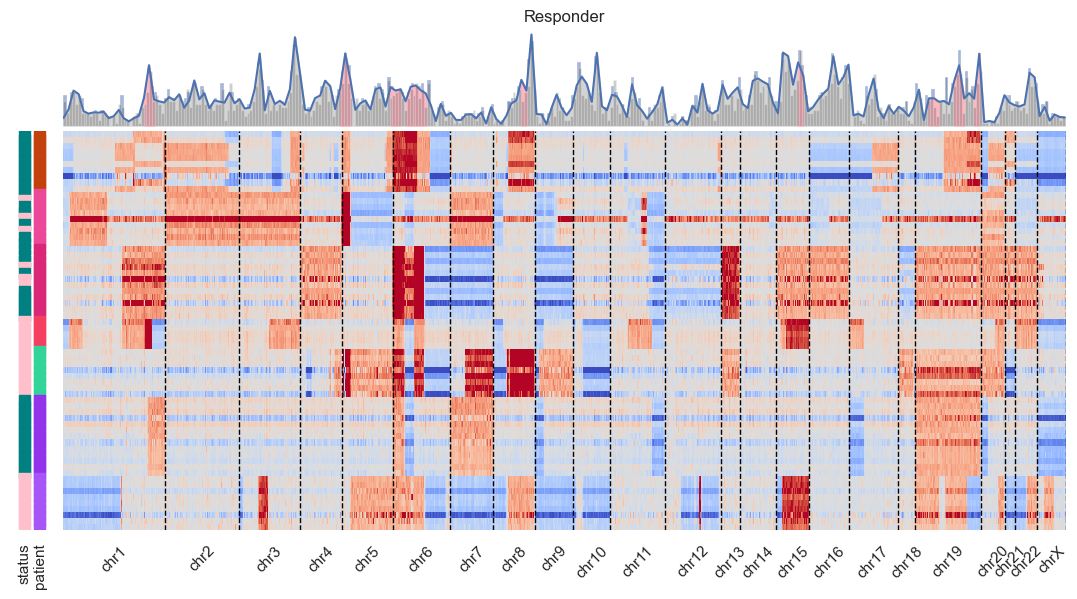

In [77]:
left, right = plot_eta_deg("Responder",res_nr.index, bw_adjust=.02, prominence=.6,
                           save=None)

In [78]:
hotspot_r = []
for i in range(len(left)):
    print(np.intersect1d(all_delta_eta.index[left[i]:right[i]], res_nr.index))
    hotspot_r += list(np.intersect1d(all_delta_eta.index[left[i]:right[i]], res_nr.index))

['AC092803.3' 'ADIPOR1' 'AL929236.1' 'ATP2B4' 'BTG2' 'CD46' 'CYB5R1'
 'DSTYK' 'DYRK3' 'EIF2D' 'ELK4' 'ETNK2' 'FCMR' 'IKBKE' 'IL19' 'IVNS1ABP'
 'KCNH1' 'KLHL12' 'MAPKAPK2' 'NIBAN1' 'NUCKS1' 'PLA2G4A' 'PPP1R15B'
 'PTGS2' 'RAB29' 'RBBP5' 'RGS1' 'RGS2' 'RNPEP' 'SHISA4' 'SLC30A1'
 'SLC41A1' 'SOX13' 'SRGAP2' 'SYT14' 'TMCC2' 'TMEM81' 'YOD1' 'ZBED6']
['AC008825.1' 'AC008875.1' 'AC010491.1' 'AC010638.1' 'AC024588.1'
 'AC025171.1' 'AC025171.2' 'AC025178.1' 'AC025181.2' 'AC034231.1'
 'AC091906.1' 'AC091978.1' 'AC106799.2' 'AC112722.1' 'AC114956.3'
 'ANKRD37' 'C5orf17' 'C5orf22' 'C5orf51' 'CARD6' 'CCL28' 'CFAP97'
 'CLPTM1L' 'CMBL' 'CYP4V2' 'DAP' 'DNAH5' 'DROSHA' 'FBXO4' 'GHR' 'GOLPH3'
 'HMGCS1' 'ICE1' 'LINC02109' 'LINC02228' 'LMBRD2' 'LPCAT1' 'MARCH6'
 'MRPS30' 'MTMR12' 'NADK2' 'NIPBL-DT' 'NNT' 'NNT-AS1' 'NSUN2' 'OTULIN'
 'PAIP1' 'PDLIM3' 'PRKAA1' 'PURPL' 'RICTOR' 'SELENOP' 'SKP2' 'SLC12A7'
 'SLC45A2' 'SNX25' 'SUB1' 'TMEM267' 'TRIO' 'TTC33' 'ZFR' 'ZNF622']
['ADTRP' 'AL024498.1' 'AL031963.3' 'AL035

In [177]:
kevin = [
    'ADORA1', 'ADORA2A', 'ADORA2B', 'AGRN', 'AGT', 'APP', 'CCL20', 'CCL21', 
    'CCL22', 'CCL28', 'CCL3', 'CCL5S', 'CCL7', 'CCL8', 'CD200', 'CD248', 
    'CD274', 'CD34', 'CD48', 'CD55', 'CD58', 'CD80', 'CD86', 'CDH1', 'CNTN1', 
    'CSF1', 'CXCL10', 'CXCL12', 'CXCL13', 'CXCL16', 'CXCL9', 'DLL3', 'DLL4', 
    'HLA-E', 'JAG1', 'JAG2', 'LGALS3', 'LGALS9', 'LPAR1', 'LPAR3', 'LTA', 
    'NCAM1', 'NECTIN2', 'NECTIN3', 'PDCD1LG2', 'PODXL', 'PODXL2', 'PTPRC', 
    'PVR', 'SELPLG', 'SEMA4D', 'SIRPA', 'TGFB1', 'TGFB2', 'TGFB3', 'THY1', 
    'TNF', 'TNFSF10', 'TNFSF4', 'TNFSF9', 'VEGFA', 'WNT4', 'WNT5A', 'WNT5B'
]

In [291]:
np.intersect1d(kevin, hotspot_r)

array(['CCL28', 'NECTIN2', 'VEGFA'], dtype='<U11')

In [178]:
gr = pd.read_csv("growing_ct_ligands_df.csv")
gr = gr[gr["log2FC"]>0]
growing_targets = gr["target"]

sh = pd.read_csv("shrinking_ct_ligands_df.csv")
sh = sh[sh["log2FC"]>0]
shrinking_targets = sh["target"]

In [203]:
gr = pd.read_csv("growing_ct_ligands_df.csv")
gr[gr['target']=="CDH1"]

Unnamed: 0             cell type target   fracExp  cell_type_dc1  \
37        1153  growing_Tumor_clones   CDH1  0.368515       0.972784   

    cell_type_dc2  cell_type_dc1_norm       absDE  absDE_scaled  \
37      -0.775446            0.657072  1007058.25      0.828067   

    numSigI1_fdr05  receptor  ligand    log2FC            fdr  \
37             0.0     False    True -0.636843  6.050352e-284   

    log10_numSigI1_fdr05  exhaust  
37                   0.0      0.0

In [292]:
np.intersect1d(growing_targets, hotspot_r)

array(['CEACAM1', 'NECTIN2', 'SEMA7A', 'VEGFA'], dtype=object)

In [293]:
np.intersect1d(shrinking_targets, hotspot_r)

array(['VEGFA'], dtype=object)

In [179]:
clin = clin.loc[:,['patient','responder']]
clin.index = clin.patient
clin = clin.drop_duplicates()

In [180]:
df = all_delta_eta.T
df.index.name = 'clusters'
df['patient_cluster'] = df.index
df['patient'] = [i.split("_")[0] for i in df['patient_cluster']]
df['responder'] = [clin.loc[i]["responder"] for i in df["patient"]]

In [185]:
res_eta = permutation_test_signed(df_features, labels=adjusted_df['responder'], label_0="Responder", label_1="Non-responder", num_permutations=1000) # ties after 10K permutations


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.26it/s]


In [186]:
# pval_corrected = fdr_correction(pval, alpha=0.05)
res_eta['p_value_adj'] = fdr_correction(res_eta['p_value'], alpha=0.05)

res_eta = res_eta[res_eta["p_value_adj"]<.05]

res_eta_r = res_eta[res_eta['test_statistic']>0]
#res_r = res_r.loc[list(np.intersect1d(deg_nr.index, res_r.index))]
res_eta_r = res_eta_r.sort_values(by='test_statistic', ascending=False)

res_eta_nr = res_eta[res_eta['test_statistic']<0]
#res_nr = res_nr.loc[list(np.intersect1d(deg.index, res_nr.index))]
res_eta_nr = res_eta_nr.sort_values(by='test_statistic', ascending=True)

In [187]:
np.intersect1d(res_eta_nr.index, kevin)

array(['CCL28', 'CDH1', 'CXCL12'], dtype=object)

In [336]:
adata.layers["z-score"] = scipy.stats.zscore(adata.to_df(), axis=0)

In [343]:
adata_eta = sc.AnnData(all_delta_eta.T)

In [ ]:
adata_eta.obs["response"]=cl_r.loc[adata_eta.obs_names]
adata_eta.obs["treatment"]=cl_treat.loc[adata_eta.obs_names]

adata_eta.obs['treat_resp'] = adata_eta.obs["treatment"]+"_"+adata_eta.obs["response"]

In [401]:
intrinsic_r = [i for i in np.intersect1d(res_eta_nr.index, res_nr.index) if "AC" not in i and "AL" not in i]

In [744]:
mean_exp = pd.DataFrame(adata.to_df()[intrinsic_r].mean(axis=0))

In [397]:
intrinsic_nr = [i for i in np.intersect1d(res_eta_r.index, res_r.index) if "AC" not in i and "AL" not in i]

In [754]:
mean_exp = pd.DataFrame(adata.to_df()[intrinsic_nr].mean(axis=0))

In [403]:
extrinsic_nr = [i for i in res_r.index if i not in res_eta_r.index]
extrinsic_r = [i for i in res_nr.index if i not in res_eta_nr.index]

In [400]:
np.intersect1d(intrinsic_nr, kevin)

array([], dtype='<U11')

In [396]:
np.intersect1d(extrinsic_nr, kevin)

array(['APP', 'NCAM1', 'PODXL2', 'WNT5A', 'WNT5B'], dtype='<U14')

In [402]:
np.intersect1d(intrinsic_r, kevin)

array(['CCL28', 'CDH1'], dtype='<U10')

In [405]:
np.intersect1d(extrinsic_r, kevin)

array(['CD58', 'LGALS3', 'LPAR3', 'NECTIN2', 'SIRPA', 'VEGFA'],
      dtype='<U12')

In [416]:
np.intersect1d(extrinsic_nr, gr["target"])

array(['APP', 'CADM1', 'CD226', 'EFNA1', 'FGF1', 'FLRT3', 'NCAM1', 'PGF',
       'PODXL2', 'PTN', 'TAFA5', 'TENM3', 'WNT5A', 'WNT5B'], dtype=object)

In [419]:
np.intersect1d(extrinsic_r, gr["target"])

array(['ANXA1', 'CCL5', 'CD58', 'CEACAM1', 'COL3A1', 'CXCL2', 'IGF1',
       'LPAR3', 'NECTIN2', 'PRNP', 'RARRES2', 'VEGFA', 'VSIR'],
      dtype=object)

In [423]:
extrinsic = list(np.intersect1d(extrinsic_nr, gr["target"]))+list(np.intersect1d(extrinsic_r, gr["target"]))

In [195]:
intrinsic_nr = [i for i in res_r.index if i in res_eta_r.index]
intrinsic_r = [i for i in res_nr.index if i in res_eta_nr.index]

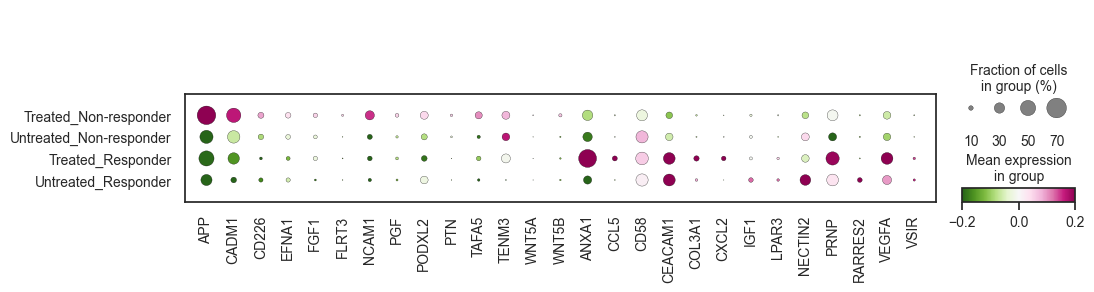

In [426]:
sc.pl.dotplot(adata, extrinsic, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.2, vmin=-.2)

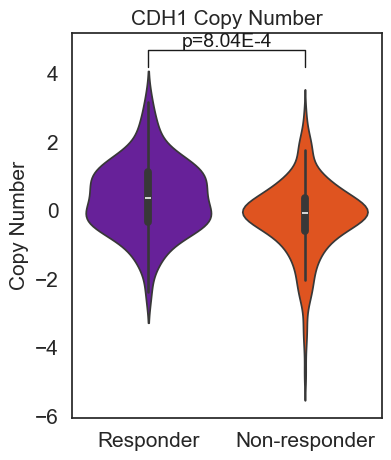

In [1447]:
gene = "CDH1"
data1 = np.asarray(all_delta_eta[cl_r[cl_r[0]=="Responder"].index].loc[gene]).flatten()
data2 = np.asarray(all_delta_eta[cl_r[cl_r[0]=="Non-responder"].index].loc[gene]).flatten()

data = [data1, data2]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#6a0dad", "#ff4500"])

# Customizing the plot
plt.xticks(ticks=[0, 1], labels=["Responder", "Non-responder"])
plt.ylabel("Values")
plt.title("Violin Plot for Two Datasets")

x1, x2 = 0,1
y, h, col = max(map(max, data)) + 1, .5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data1, data2)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)
plt.ylabel("Copy Number")
plt.title(gene+" Copy Number")
plt.savefig("mel_figures/figure_3_new/CDH1_eta.pdf")

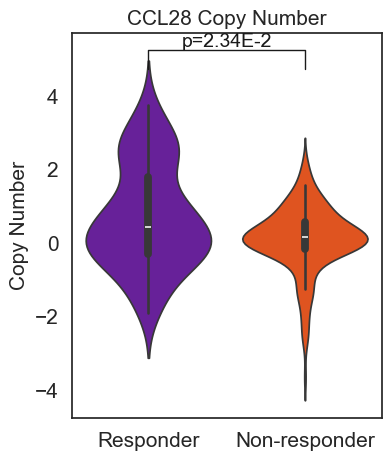

In [1448]:
gene = "CCL28"
data1 = np.asarray(all_delta_eta[cl_r[cl_r[0]=="Responder"].index].loc[gene]).flatten()
data2 = np.asarray(all_delta_eta[cl_r[cl_r[0]=="Non-responder"].index].loc[gene]).flatten()

data = [data1, data2]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#6a0dad", "#ff4500"])

# Customizing the plot
plt.xticks(ticks=[0, 1], labels=["Responder", "Non-responder"])
plt.ylabel("Values")
plt.title("Violin Plot for Two Datasets")

x1, x2 = 0,1
y, h, col = max(map(max, data)) + 1, .5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data1, data2)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)
plt.ylabel("Copy Number")
plt.title(gene+" Copy Number")
plt.savefig("mel_figures/figure_3_new/CCL28_eta.pdf")

In [66]:
wouters = pd.read_csv("wouters_mel_sigs.csv", index_col=None)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2211249463.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

## Global cohort eta vs exp correlations 

In [156]:
corrs = []
exp_norm_np = np.asarray(exp_norm.loc[all_delta_eta.index][all_delta_eta.columns])
all_eta_np = np.asarray(all_delta_eta)
for i in range(all_delta_eta.shape[0]):
    corrs.append(scipy.stats.pearsonr(all_eta_np[i,:], exp_norm_np[i,:]))

In [157]:
corrs = pd.DataFrame(corrs, index=all_delta_eta.index)

In [160]:
# pval_corrected = fdr_correction(pval, alpha=0.05)
corrs['p_value_adj'] = fdr_correction(corrs['pvalue'], alpha=0.05)

#### Extrinsic 

In [1226]:
corrs["abs_stat"] = abs(corrs["statistic"])
low_corr_r = corrs.loc[np.intersect1d(res_nr.index, corrs.index)].sort_values(by="abs_stat").iloc[0:30].index

In [813]:
esr2 = [
    "ESR2", "ESR1", "CYP19A1", "HSP90AA1",
    "NCOA1", "NCOA2", "NCOA3",
    "NCOR1", "NCOR2",
    "CREBBP", "EP300",
    "PTEN", "CDKN1A", "CCND1", "IL6", "TNF", "TP53", "BCL2"
]

In [814]:
np.intersect1d(esr2, res_nr.index)

array(['EP300', 'ESR2'], dtype=object)

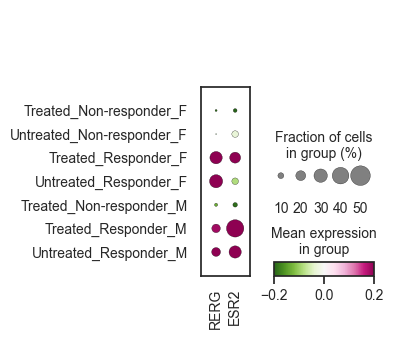

In [840]:
sc.pl.dotplot(adata, ["RERG","ESR2"], layer='z-score', groupby='treat_resp_gender', categories_order = ['Treated_Non-responder_F','Untreated_Non-responder_F',
                                                   'Treated_Responder_F',"Untreated_Responder_F", 'Treated_Non-responder_M',
                                                   'Treated_Responder_M',"Untreated_Responder_M"], cmap='PiYG_r', vmax=.2, vmin=-.2)

In [846]:
for i in np.unique(obs["treat_resp_gender"]):   
    print(i, np.unique(obs[obs["treat_resp_gender"]==i]["patient"]))

Treated_Non-responder_F ['F01' 'F06' 'F09' 'F12' 'F23' 'F26' 'F28' 'R319' 'R334']
Treated_Non-responder_M ['F03' 'F07' 'F08' 'F20' 'F22' 'F29' 'F30' 'F31' 'R294' 'R328' 'R329'
 'R354']
Treated_Responder_F ['F17' 'F18']
Treated_Responder_M ['F02' 'F27' 'R310']
Untreated_Non-responder_F ['F01' 'F04' 'F12' 'F15']
Untreated_Responder_F ['F16']
Untreated_Responder_M ['F02' 'F05' 'R310']


In [876]:
clin = clin.loc[:,['patient','Gender']]
clin.index = clin.patient
clin = clin.drop_duplicates()

In [880]:
df = exp_norm[[i for i in exp_norm.columns if cl_treat.loc[i][0]=="Treated"]].T
df.index.name = 'clusters'
df['patient_cluster'] = df.index
df['patient'] = [i.split("_")[0] for i in df['patient_cluster']]
df['gender'] = [clin.loc[i]["Gender"] for i in df["patient"]]
#df['cluster'] = df['patient_cluster'].apply(lambda x:x.split('_')[-1])
df.head()

genes        ISG15      AGRN  C1orf159  AL390719.3   TNFRSF4      SDF4  \
clusters                                                                 
F01_0     0.000000  0.063349  0.076115    0.004213  0.000308  0.114829   
F01_1     0.000000  0.092585  0.080570    0.005883  0.000000  0.133589   
F01_3     0.000862  0.075935  0.071282    0.003488  0.000708  0.144182   
F01_4     0.003543  0.062411  0.049367    0.000000  0.000724  0.116339   
F01_5     0.003666  0.081286  0.113286    0.009229  0.000000  0.128912   

genes      B3GALT6  C1QTNF12    UBE2J2  LINC01786  ...  CXorf40B  LINC00894  \
clusters                                           ...                        
F01_0     0.021357  0.000313  0.036750   0.005374  ...  0.066755   0.283673   
F01_1     0.026705  0.001040  0.042016   0.005756  ...  0.067658   0.321169   
F01_3     0.025002  0.000843  0.040172   0.003002  ...  0.082728   0.299832   
F01_4     0.022834  0.001531  0.033103   0.002855  ...  0.050743   0.195501   
F01_5     0.025388  0.000420  0.038795   0.004863  ...  0.063305   0.204330   

genes       MAMLD1      MTM1     MTMR1    CD99L2     HMGB3  patient_cluster  \
clusters                                                                      
F01_0     0.400011  0.174543  0.221855  0.188048  0.000241            F01_0   
F01_1     0.427355  0.174296  0.218881  0.228333  0.002146            F01_1   
F01_3     0.419769  0.158455  0.229099  0.214859  0.001108            F01_3   
F01_4     0.301354  0.113300  0.165751  0.176847  0.004364            F01_4   
F01_5     0.398591  0.148846  0.259605  0.277496  0.058151            F01_5   

genes     patient  gender  
clusters                   
F01_0         F01       F  
F01_1         F01       F  
F01_3         F01       F  
F01_4         F01       F  
F01_5         F01       F  

[5 rows x 17171 columns]

In [881]:
adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)
adjusted_df = df.reset_index(drop=True)

df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')
df_features.head()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/3950644579.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/3950644579.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')


genes     ISG15      AGRN  C1orf159  AL390719.3   TNFRSF4      SDF4   B3GALT6  \
0      0.000000  0.063349  0.076115    0.004213  0.000308  0.114829  0.021357   
1      0.000000  0.092585  0.080570    0.005883  0.000000  0.133589  0.026705   
2      0.000862  0.075935  0.071282    0.003488  0.000708  0.144182  0.025002   
3      0.003543  0.062411  0.049367    0.000000  0.000724  0.116339  0.022834   
4      0.003666  0.081286  0.113286    0.009229  0.000000  0.128912  0.025388   

genes  C1QTNF12    UBE2J2  LINC01786  ...  LINC00893  CXorf40A  TMEM185A  \
0      0.000313  0.036750   0.005374  ...   0.139117  0.030765  0.151544   
1      0.001040  0.042016   0.005756  ...   0.132243  0.034191  0.163791   
2      0.000843  0.040172   0.003002  ...   0.138915  0.030147  0.157924   
3      0.001531  0.033103   0.002855  ...   0.089294  0.029018  0.124376   
4      0.000420  0.038795   0.004863  ...   0.071252  0.027095  0.138704   

genes  CXorf40B  LINC00894    MAMLD1      MTM1     MTMR1    CD99L2     HMGB3  
0      0.066755   0.283673  0.400011  0.174543  0.221855  0.188048  0.000241  
1      0.067658   0.321169  0.427355  0.174296  0.218881  0.228333  0.002146  
2      0.082728   0.299832  0.419769  0.158455  0.229099  0.214859  0.001108  
3      0.050743   0.195501  0.301354  0.113300  0.165751  0.176847  0.004364  
4      0.063305   0.204330  0.398591  0.148846  0.259605  0.277496  0.058151  

[5 rows x 17168 columns]

In [884]:
mf_res = permutation_test_signed(df_features, labels=adjusted_df['gender'], label_0="M", label_1="F", num_permutations=1000) # ties after 10K permutations

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.33it/s]


In [888]:
mf_res['p_value_adj'] = fdr_correction(mf_res['p_value'], alpha=0.05)
mf_res = mf_res[mf_res["p_value_adj"]<.05]

In [897]:
for i in mf_res[mf_res["test_statistic"]<0].index:
    if ("JAK" in i) or ("STAT" in i) or ("IRF" in i):
        print(i)

JAK1
IRF2
IRF2BPL
IRF3


In [ ]:
f_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="F"].index, obs[obs["responder"]=="Responder"].index)]
m_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="M"].index, obs[obs["responder"]=="Responder"].index)]
ts = []
for gene in res_nr.index:
    ts.append(scipy.stats.ttest_ind(f_df[gene], m_df[gene]))

mf_res = pd.DataFrame(ts, index=res_nr.index)
mf_res['p_value_adj'] = fdr_correction(mf_res['pvalue'], alpha=0.05)

mf_res = mf_res[mf_res["p_value_adj"]<.05]

In [898]:
f_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="F"].index, obs[obs["responder"]=="Non-responder"].index)]
m_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="M"].index, obs[obs["responder"]=="Non-responder"].index)]
ts = []
for gene in res_r.index:
    ts.append(scipy.stats.ttest_ind(f_df[gene], m_df[gene]))

mf_res = pd.DataFrame(ts, index=res_r.index)
mf_res['p_value_adj'] = fdr_correction(mf_res['pvalue'], alpha=0.05)

In [957]:
cl_rp = pd.DataFrame()
for i in cl_r.index:
    if i.split("_")[0] not in cl_rp.columns:
        cl_rp[i.split("_")[0]]=[cl_r.loc[i][0]]
cl_rp = cl_rp.T

In [962]:
clin = pd.read_csv("clin.csv")
clin = clin.loc[:,['patient','Gender']]
clin.index = clin.patient

In [971]:
order = [i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="M"] +[i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="F"] +[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="M"] +[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="F"]


/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/2997254881.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  order = [i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="M"] +[i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="F"] +[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="M"] +[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="F"]


In [974]:
[i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="M"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/16080252.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="M"]


['F03',
 'F22',
 'F20',
 'F08',
 'R294',
 'F30',
 'F29',
 'F07',
 'F31',
 'R329',
 'R328',
 'R354']

In [975]:
[i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="F"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/499779333.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [i for i in cl_rp[cl_rp[0]=="Non-responder"].index if clin.loc[i]["Gender"][0]=="F"]


['F12', 'R319', 'F01', 'F06', 'F23', 'F28', 'F09', 'F26', 'F04', 'F15', 'R334']

In [976]:
[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="M"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/567271466.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="M"]


['F02', 'R310', 'F27', 'F05']

In [977]:
[i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="F"]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/1271275255.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [i for i in cl_rp[cl_rp[0]=="Responder"].index if clin.loc[i]["Gender"][0]=="F"]


['F16', 'F18', 'F17']

In [67]:
sig_df = pd.DataFrame()
df = adata.to_df()
for sig in wouters.columns:
    s = [i for i in wouters[sig] if not pd.isna(i) and i in adata.var_names]
    sig_df[sig] = df[s].mean(axis=1)

sig_df = sc.AnnData(sig_df)
sig_df.obs = adata.obs

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/1730406180.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sig_df[sig] = df[s].mean(axis=1)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/1730406180.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sig_df[sig] = df[s].mean(axis=1)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/1730406180.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [68]:
sig_df.layers['z-score'] = scipy.stats.zscore(sig_df.to_df(), axis=0)

In [938]:
clin = pd.read_csv("clin.csv")
clin = clin.loc[:,['patient','responder']]
clin.index = clin.patient
clin = clin.drop_duplicates()

df = all_delta_eta.T
df.index.name = 'clusters'
df['patient_cluster'] = df.index
df['patient'] = [i.split("_")[0] for i in df['patient_cluster']]
df['responder'] = [clin.loc[i]["responder"] for i in df["patient"]]

adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)

adjusted_df = df.reset_index(drop=True)

df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')
df_features.head()

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/3342631877.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  adjusted_df = df.groupby('patient').apply(lambda x: adjust_clusters(x)).reset_index(drop=True)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/3342631877.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_features = adjusted_df.iloc[:,:-3].applymap(pd.to_numeric, errors='coerce')


ISG15      AGRN  C1orf159  AL390719.3   TNFRSF4      SDF4   B3GALT6  \
0  0.298410 -1.033910 -0.314517    0.243242  0.707694 -0.890867 -0.855242   
1 -0.162132  0.423535  0.654844   -0.286965 -0.331548  0.315377  0.162533   
2  0.797255  0.394700 -0.270441    0.332194  0.178013  0.469533  0.099507   
3 -0.485993  0.428187  0.658006   -0.248170 -0.577653  0.651376  0.347798   
4 -0.021701 -0.021222  0.610345   -0.190836 -0.464340  0.562197  0.690888   

   C1QTNF12    UBE2J2  LINC01786  ...  LINC00893  CXorf40A  TMEM185A  \
0  0.710128 -0.648379   0.644246  ...  -0.545372  0.154006 -1.056281   
1 -0.443664  0.185063  -0.199472  ...   0.413616 -0.024193  0.611325   
2  0.471609 -0.034549   0.092681  ...  -0.165725 -0.123724 -0.088802   
3 -0.489468  0.256742  -0.363584  ...   0.038500  0.293001  0.527378   
4 -0.197408  0.416410  -0.418400  ...   0.303524  0.145827  0.768039   

   CXorf40B  LINC00894    MAMLD1      MTM1     MTMR1    CD99L2     HMGB3  
0 -0.465133  -0.306826 -1.039194 -0.597677 -0.801637 -0.943455  0.508607  
1  0.380833   1.048271  0.335196  0.730608  0.550244  0.477905 -0.428532  
2 -0.379101  -0.603813 -0.388549 -0.576889 -0.155854  0.207507  0.244446  
3  0.391773   0.677308  0.672012  0.686125  0.756667  0.267285 -0.581472  
4  0.518675   0.321894  1.476437  0.541230  0.475317  0.316896 -0.255375  

[5 rows x 17168 columns]

In [939]:
df_sig_features = pd.DataFrame()
for s in wouters.columns:
    sig = [i for i in wouters[s] if not pd.isna(i)]
    sig = np.intersect1d(sig, df_features.columns)
    df_sig_features[s] = df_features[sig].mean(axis=1)

#order of clust is the same so can use same adjusted df labels

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/2124398605.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sig_features[s] = df_features[sig].mean(axis=1)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/2124398605.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sig_features[s] = df_features[sig].mean(axis=1)
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_9901/2124398605.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [940]:
res_sig = permutation_test_signed(df_sig_features, labels=adjusted_df['responder'], label_0="Responder", label_1="Non-responder", num_permutations=1000) # ties after 10K permutations

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.93it/s]


In [941]:
res_sig['p_value_adj'] = fdr_correction(res_sig['p_value'], alpha=0.05)

In [942]:
res_sig[res_sig["p_value_adj"]<.05]

Empty DataFrame
Columns: [test_statistic, p_value, p_value_adj]
Index: []

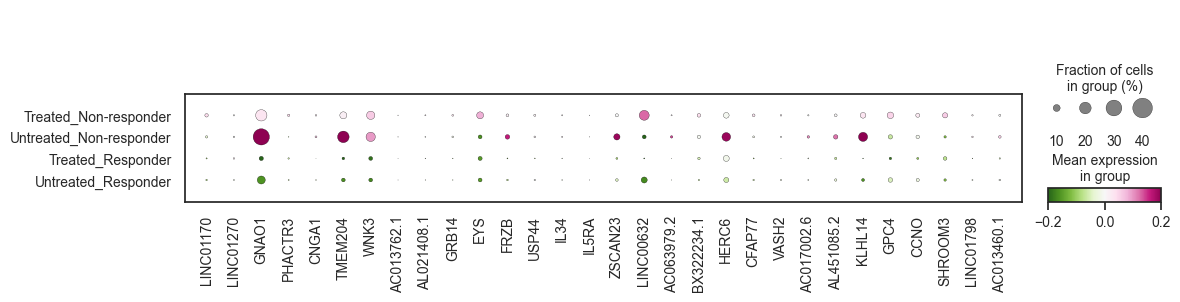

In [739]:
low_corr_nr = corrs.loc[np.intersect1d(res_r.index, corrs.index)].sort_values(by="abs_stat").iloc[0:30].index
sc.pl.dotplot(adata, low_corr_nr, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.2, vmin=-.2)

#### Intrinsic

In [161]:
corrs = corrs.sort_values(by='statistic', ascending=False)
corrs = corrs[corrs["p_value_adj"]<.05]
corrs = corrs[corrs["statistic"]>0]

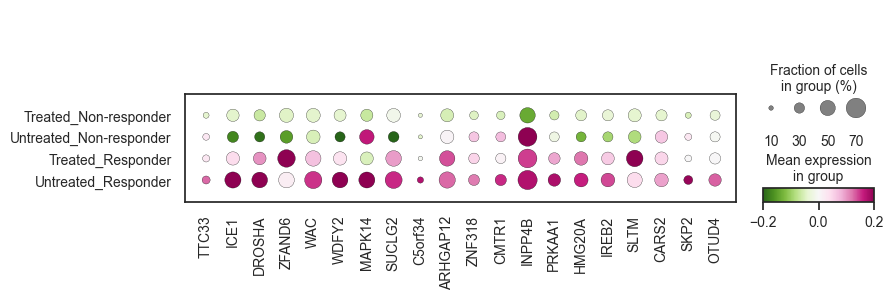

In [631]:
high_corr_r = corrs.loc[np.intersect1d(res_nr.index, corrs.index)].sort_values(by="statistic", ascending=False).iloc[0:20].index
sc.pl.dotplot(adata, high_corr_r, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.2, vmin=-.2)

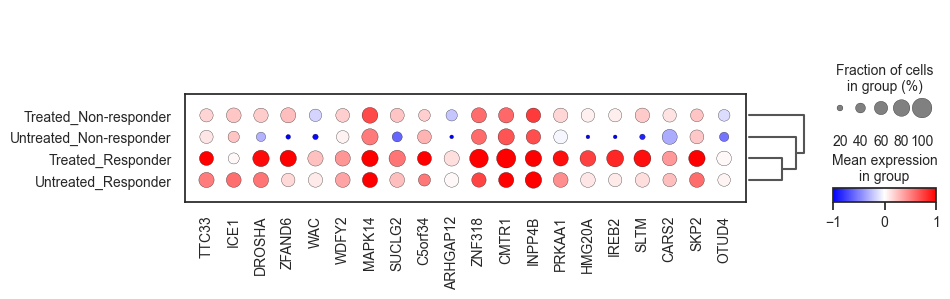

In [632]:
sc.pl.dotplot(adata_eta, high_corr_r, groupby='treat_resp', cmap='bwr', vmax=1, vmin=-1,dendrogram=True)

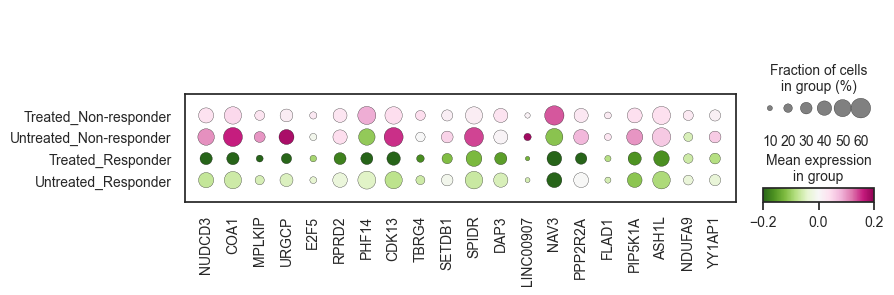

In [724]:
high_corr_nr = corrs.loc[np.intersect1d(res_r.index, corrs.index)].sort_values(by="statistic", ascending=False).iloc[0:20].index
sc.pl.dotplot(adata, high_corr_nr, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.2, vmin=-.2)

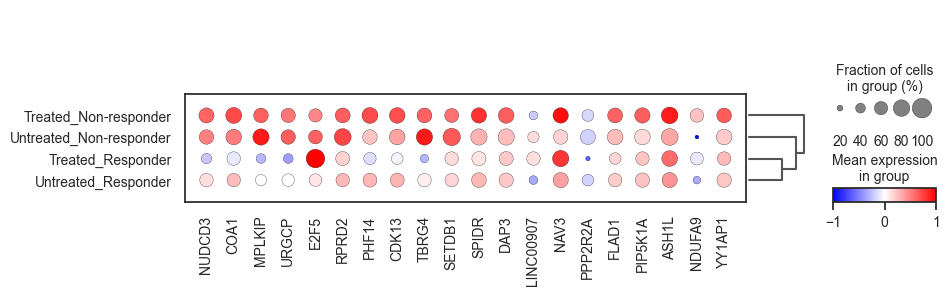

In [726]:
sc.pl.dotplot(adata_eta, high_corr_nr, groupby='treat_resp', cmap='bwr', vmax=1, vmin=-1,dendrogram=True)

### Cluster level fraction > percentile

In [721]:
rs = []
nrs = []
for i in range(len(high_corr_r)):
    p95 = np.percentile(exp_norm.loc[high_corr_r[i]][all_delta_eta.columns], 85)
    tmp = exp_norm.loc[high_corr_r[i]][cl_r[cl_r[0]=="Responder"].index]
    tmp = pd.DataFrame(tmp)
    rs.append(tmp[tmp[high_corr_r[i]]>p95].shape[0]/cl_r[cl_r[0]=="Responder"].shape[0])
    tmp = exp_norm.loc[high_corr_r[i]][cl_r[cl_r[0]=="Non-responder"].index]
    tmp = pd.DataFrame(tmp)
    nrs.append(tmp[tmp[high_corr_r[i]]>p95].shape[0]/cl_r[cl_r[0]=="Non-responder"].shape[0])

In [722]:
pd.DataFrame({"R_fracs":rs,"NR_fracs":nrs}, index = high_corr_r)

R_fracs  NR_fracs
TTC33     0.348485  0.086294
ICE1      0.212121  0.131980
DROSHA    0.333333  0.091371
ZFAND6    0.196970  0.137056
WAC       0.227273  0.126904
WDFY2     0.227273  0.126904
MAPK14    0.303030  0.101523
SUCLG2    0.196970  0.137056
C5orf34   0.242424  0.121827
ARHGAP12  0.181818  0.142132
ZNF318    0.318182  0.096447
CMTR1     0.272727  0.111675
INPP4B    0.196970  0.137056
PRKAA1    0.272727  0.111675
HMG20A    0.257576  0.116751
IREB2     0.333333  0.091371
SLTM      0.212121  0.131980
CARS2     0.257576  0.116751
SKP2      0.303030  0.101523
OTUD4     0.212121  0.131980

## FGA

In [984]:
gtf = pd.read_csv("ichorCNA_cellranger_gtf_gene_map.csv", index_col=0)

In [995]:
lengths = []
i=0
for gene in all_delta_eta.index:
    if i%1000==0:
        print(i)
    length = max(gtf[gtf["gene_name"]==gene]["end"]) - min(gtf[gtf["gene_name"]==gene]["start"])
    lengths.append(length)
    i+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [ ]:
gene_lens = pd.DataFrame(lengths, index=all_delta_eta.index)
gene_lens.columns = ["bp"]

gene_lens.to_csv("gene_lengths.csv")

gene_lens = pd.read_csv("gene_lengths.csv", index_col=0)

lower = np.percentile(np.asarray(all_delta_eta).flatten(),25)
upper = np.percentile(np.asarray(all_delta_eta).flatten(),75)

In [181]:
fga = pd.DataFrame()
for clust in all_delta_eta.columns:
    alt = 0
    for i in all_delta_eta.index:
        val = all_delta_eta.loc[i][clust]
        if val>upper or val<lower:
            alt += gene_lens.loc[i]["bp"]
    fga[clust] = [alt/np.sum(gene_lens["bp"])]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/384139633.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fga[clust] = [alt/np.sum(gene_lens["bp"])]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/384139633.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fga[clust] = [alt/np.sum(gene_lens["bp"])]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/384139633.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

Text(0, 0.5, 'ZFAND6 expression')

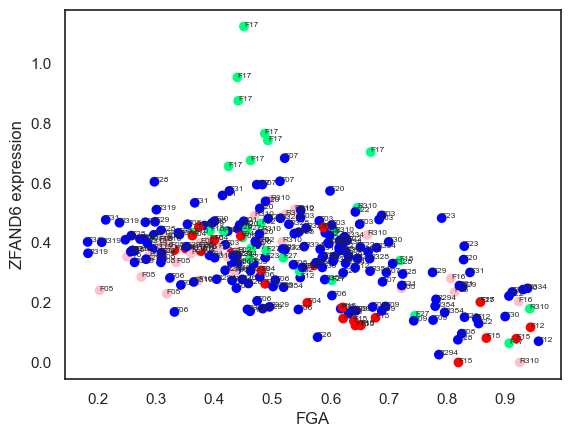

In [1083]:
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc["ZFAND6"][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc["ZFAND6"][i], i.split("_")[0], size=6)
plt.xlabel("FGA")
plt.ylabel("ZFAND6 expression")

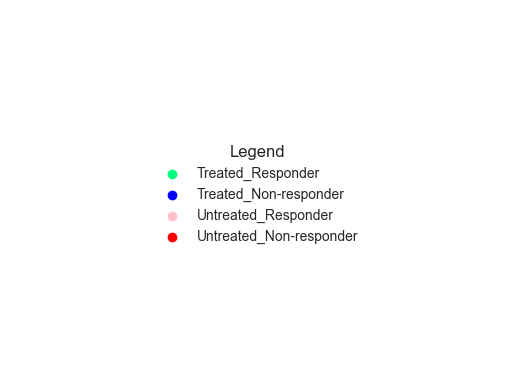

In [1470]:
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
for i, (label, color) in enumerate(pal.items()):
    plt.scatter([], [], color=color, label=label)
    
plt.legend(title="Legend", loc='center', frameon=False, ncol=1, fontsize=10, title_fontsize=12)
plt.axis('off')
plt.savefig("mel_figures/figure_3_new/pt_statuses.pdf", bbox_inches='tight')

In [182]:
cin_corrs = []
for gene in exp_norm.index:
    corr = scipy.stats.pearsonr(list(fga.loc[0]), list(exp_norm.loc[gene][fga.columns]))
    cin_corrs.append(corr)

In [183]:
cin_corrs = pd.DataFrame(cin_corrs, index=exp_norm.index)

In [1095]:
cin_corrs.sort_values(by="statistic").iloc[0:20]

statistic        pvalue
genes                            
WAC       -0.585856  1.244506e-25
GSK3B     -0.546705  6.714520e-22
ZNF207    -0.535803  6.048621e-21
TBCK      -0.527869  2.850454e-20
NF1       -0.526396  3.783822e-20
RBM25     -0.524725  5.210379e-20
TTC17     -0.524605  5.330700e-20
PHIP      -0.519852  1.310793e-19
MAP3K7    -0.513910  3.957094e-19
DNAJB14   -0.511340  6.339690e-19
CCNC      -0.508957  9.780441e-19
PCNX4     -0.507193  1.345105e-18
MNAT1     -0.505564  1.802380e-18
JMJD1C    -0.505165  1.936044e-18
PHKB      -0.504332  2.246549e-18
PPA2      -0.503895  2.428924e-18
SLC25A36  -0.496625  8.736600e-18
RAP1GDS1  -0.494275  1.313080e-17
CUL5      -0.492688  1.725864e-17
NSRP1     -0.491798  2.010265e-17

In [1102]:
cin_corrs['p_value_adj'] = fdr_correction(cin_corrs['pvalue'], alpha=0.05)

In [185]:
cin_corrs.loc[["ZFAND6","INO80","CTCF","SMARCAD1"]]

statistic        pvalue
genes                            
ZFAND6    -0.447899  2.215440e-14
INO80     -0.429940  2.947316e-13
CTCF      -0.392295  4.166829e-11
SMARCAD1  -0.449164  1.835432e-14

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


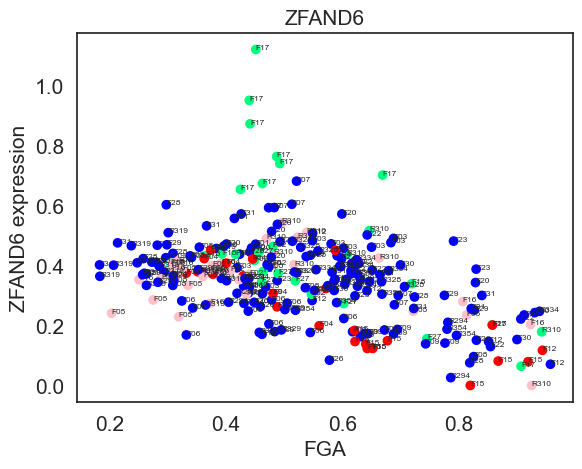

In [1439]:
g = "ZFAND6"
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc[g][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc[g][i], i.split("_")[0], size=6)
plt.xlabel("FGA")
plt.ylabel(g+" expression")
plt.title(g)
plt.savefig("mel_figures/figure_3_new/ZFAND6_scatter.pdf")

In [ ]:
NPAT, INO80, SMARCAD1, or CTCF 

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


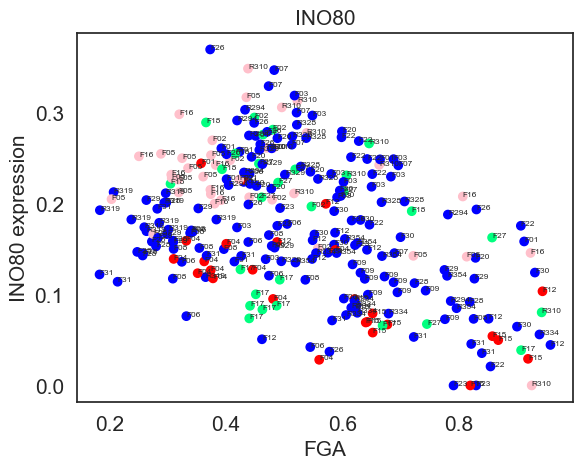

In [1477]:
g = "INO80"
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc[g][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc[g][i], i.split("_")[0], size=6)
plt.ylabel(g+" expression")
plt.title(g)
plt.xlabel("FGA")
plt.savefig("mel_figures/figure_3_new/INO80_scatter.pdf")

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


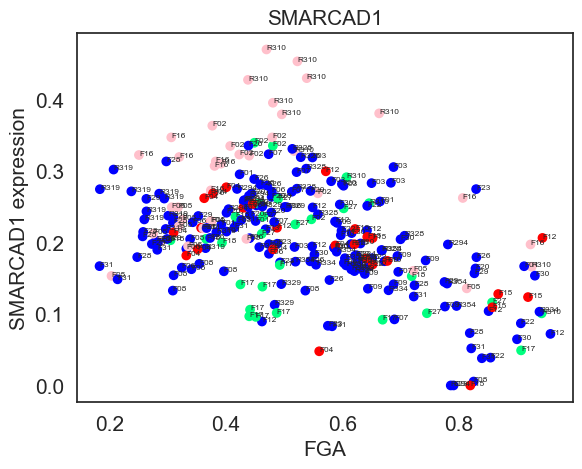

In [1478]:
g = "SMARCAD1"
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc[g][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc[g][i], i.split("_")[0], size=6)
plt.xlabel("FGA")
plt.ylabel(g+" expression")
plt.xlabel("FGA")
plt.title(g)
plt.savefig("mel_figures/figure_3_new/SMARCAD1_scatter.pdf")

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


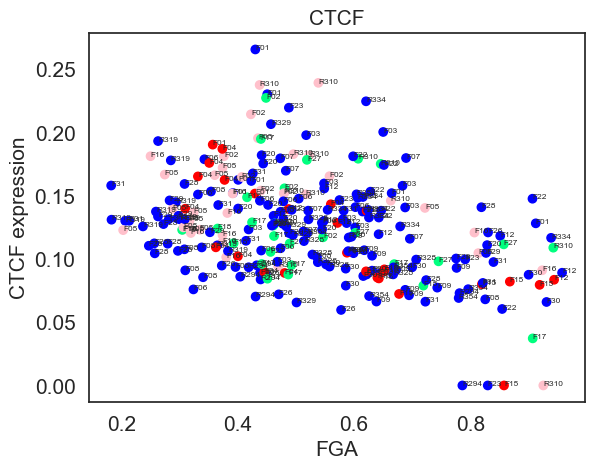

In [1479]:
g = "CTCF"
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc[g][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc[g][i], i.split("_")[0], size=6)
plt.ylabel(g+" expression")
plt.title(g)
plt.xlabel("FGA")
plt.savefig("mel_figures/figure_3_new/CTCF_scatter.pdf")

Text(0.5, 1.0, 'CFB')

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


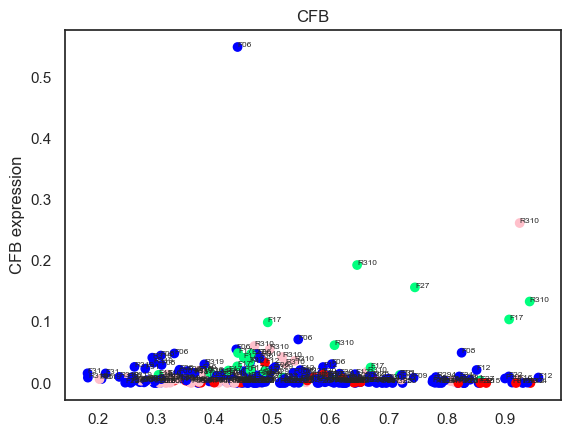

In [1371]:
g = "CFB"
pal = {"Treated_Responder":"springgreen","Treated_Non-responder":"blue", "Untreated_Responder":"pink","Untreated_Non-responder":"red"}
plt.scatter(fga, exp_norm.loc[g][fga.columns],c=[pal[cl_rt.loc[i][0]] for i in fga.columns])
for i in fga.columns:
    plt.text(fga[i], exp_norm.loc[g][i], i.split("_")[0], size=6)
plt.ylabel(g+" expression")
plt.title(g)

In [1104]:
cin_corrs = cin_corrs[cin_corrs["p_value_adj"]<.05]

In [1117]:
cin_corrs.loc[np.intersect1d(cin_corrs.index,res_nr.index)].sort_values(by="statistic").iloc[0:100].index

Index(['WAC', 'ZNF207', 'TBCK', 'DNAJB14', 'PCNX4', 'SLC25A36', 'ZNF410',
       'USP10', 'PNN', 'PCF11', 'SOS2', 'SLF2', 'ANKRD26', 'EXOC5', 'SNX19',
       'UBE2D3', 'NPAT', 'MLLT10', 'CCSER2', 'PUS10', 'PPP3R1', 'CARS2',
       'DOP1A', 'NCEH1', 'ZC3H14', 'SMARCAD1', 'C4orf33', 'LINC00513', 'UPF2',
       'TTC14', 'ZFAND6', 'MAP4K3-DT', 'WDR41', 'PSEN1', 'PPIL3', 'MMS19',
       'ABI1', 'ACSF3', 'PCSK7', 'RREB1', 'TASOR', 'SFSWAP', 'INO80', 'MAP4K3',
       'INTS12', 'TMEM14B', 'ZFYVE1', 'RABL3', 'IREB2', 'YTHDF2', 'NAALADL2',
       'JKAMP', 'SF1', 'PLD1', 'AP2B1', 'N4BP1', 'PHF12', 'HNRNPDL', 'LCOR',
       'AL157392.3', 'DCUN1D1', 'INO80D', 'TNIK', 'NHLRC3', 'RIPK1', 'OPA1',
       'HNRNPLL', 'ARMH3', 'KLC1', 'IWS1', 'PPP2R5E', 'RARS2', 'SNX14',
       'PDSS1', 'TCAIM', 'VPS26C', 'PDLIM5', 'PIGV', 'DISC1', 'DARS', 'SETD3',
       'ZFYVE27', 'SRSF5', 'UIMC1', 'SLC38A6', 'INPP4B', 'CARMIL1', 'IBTK',
       'ADAM17', 'TRPM7', 'SLC35B3', 'MSS51', 'ZFYVE28', 'NFKB1', 'CTCF',
       'P

In [1422]:
def T_R_boxplot(g):
    data1 = list(exp_norm[cl_rt[cl_rt[0]=="Untreated_Responder"].index].loc[g])
    data2 = list(exp_norm[cl_rt[cl_rt[0]=="Untreated_Non-responder"].index].loc[g])
    data3 = list(exp_norm[cl_rt[cl_rt[0]=="Treated_Responder"].index].loc[g])
    data4 = list(exp_norm[cl_rt[cl_rt[0]=="Treated_Non-responder"].index].loc[g])
    
    data = [data1, data2, data3, data4]
    
    
    # Creating the violin plot
    plt.figure(figsize=(4, 5))
    sns.violinplot(data=data, palette=["#F79F79", "#F7D08A", "#E3F09B", "#87B6A7"])
    
    # Customizing the plot
    plt.xticks(ticks=[0, 1, 2, 3], labels=["Untreated_Responder", "Untreated_Non-responder","Treated_Responder","Treated_Non-responder"], rotation=45)
    plt.ylabel("Expression")
    plt.title(g)
    
    x1, x2 = 0,1
    y, h, col = max(map(max, data)), .05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    p = scipy.stats.mannwhitneyu(data1, data2)[1]
    p = "{:.2E}".format(Decimal(p))
    plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)
    
    x1, x2 = 2,3
    y, h, col = max(map(max, data)), .2+.17, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    p = scipy.stats.mannwhitneyu(data3, data4)[1]
    p = "{:.2E}".format(Decimal(p))
    plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)

In [1433]:
plt.rcParams.update({'font.size': 14})
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)

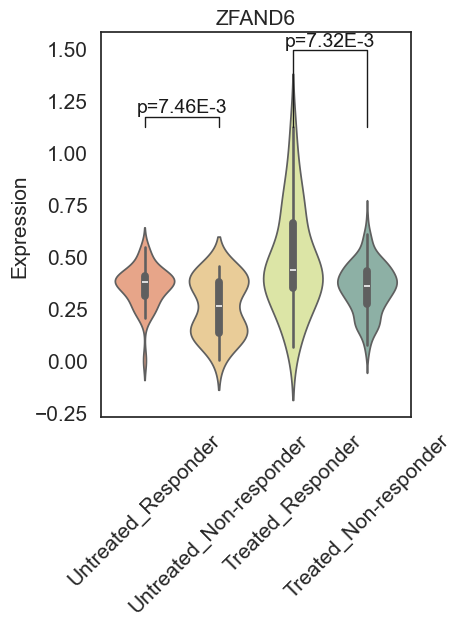

In [1434]:
T_R_boxplot("ZFAND6")
plt.savefig("mel_figures/figure_3_new/ZFAND6.pdf", bbox_inches='tight')

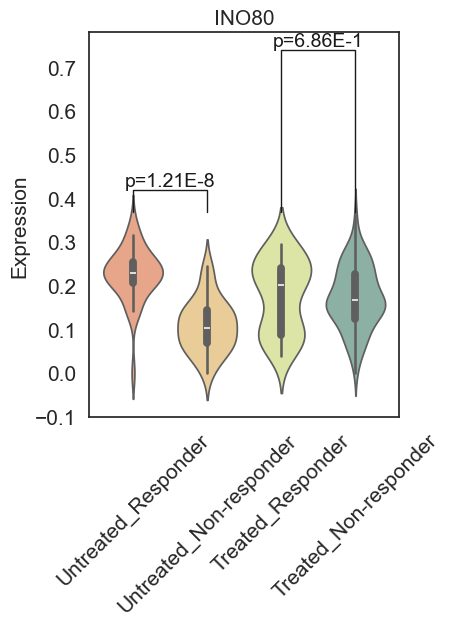

In [1442]:
T_R_boxplot("INO80")
plt.savefig("mel_figures/figure_3_new/INO80.pdf", bbox_inches='tight')

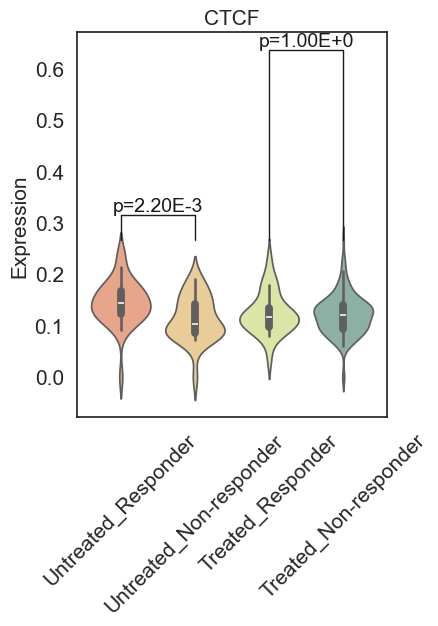

In [1443]:
T_R_boxplot("CTCF")
plt.savefig("mel_figures/figure_3_new/CTCF.pdf", bbox_inches='tight')

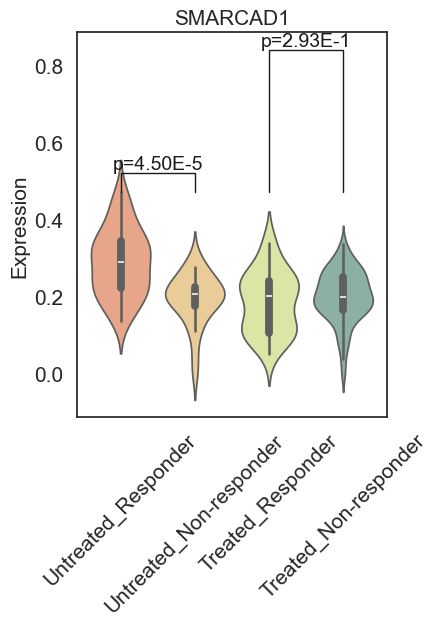

In [1437]:
T_R_boxplot("SMARCAD1")
plt.savefig("mel_figures/figure_3_new/SMARCAD1.pdf")

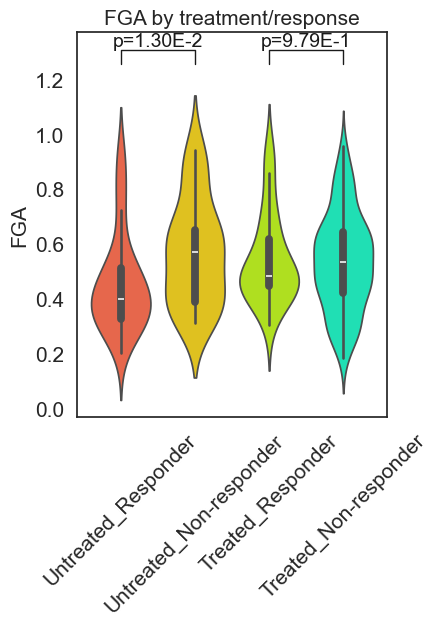

In [1444]:
data1 = list(fga.loc[0][cl_rt[cl_rt[0]=="Untreated_Responder"].index])
data2 = list(fga.loc[0][cl_rt[cl_rt[0]=="Untreated_Non-responder"].index])
data3 = list(fga.loc[0][cl_rt[cl_rt[0]=="Treated_Responder"].index])
data4 = list(fga.loc[0][cl_rt[cl_rt[0]=="Treated_Non-responder"].index])

data = [data1, data2, data3, data4]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#FF5733", "#FFD700", "#BFFF00", "#00FFC6"])

# Customizing the plot
plt.xticks(ticks=[0, 1, 2, 3], labels=["Untreated_Responder", "Untreated_Non-responder","Treated_Responder","Treated_Non-responder"], rotation=45)
plt.ylabel("FGA")
plt.title("FGA by treatment/response")

x1, x2 = 0,1
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data1, data2)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)

x1, x2 = 2,3
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data3, data4)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)
plt.savefig("mel_figures/figure_3_new/FGA.pdf", bbox_inches='tight')

In [1245]:
data3 = pd.DataFrame(fga.loc[0][cl_rt[cl_rt[0]=="Treated_Responder"].index])
data3[data3[0]>np.quantile(data3, .75)]

0
R310_5            0.942287
R310_6            0.645805
F18_post_0        0.719073
F27_post1_pre2_3  0.857122
F27_post1_pre2_7  0.745092
F17_post_2        0.669012
F17_post_6        0.906938

In [1257]:
df_sig_features = exp_norm[data3.index]

In [1261]:
adjusted_df = []
for i in df_sig_features.columns:
    if data3.loc[i][0]<np.quantile(data3, .75):
        adjusted_df.append("low_cin")
    else:
        adjusted_df.append("high_cin")
adjusted_df = pd.DataFrame(adjusted_df)

In [1263]:
adjusted_df.columns = ['cin_state']

In [1266]:
adjusted_df.index = df_sig_features.columns

In [1308]:
res = permutation_test_signed(df_sig_features.T, labels=adjusted_df['cin_state'], label_0="low_cin", label_1="high_cin", num_permutations=1000) # ties after 10K permutations

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 495.47it/s]


In [1309]:
# pval_corrected = fdr_correction(pval, alpha=0.05)
res['p_value_adj'] = fdr_correction(res['p_value'], alpha=0.05)

res = res[res["p_value_adj"]<.05]

res_high = res[res['test_statistic']>0]
#res_r = res_r.loc[list(np.intersect1d(deg_nr.index, res_r.index))]
res_high = res_high.sort_values(by='test_statistic', ascending=False)

res_low = res[res['test_statistic']<0]
#res_nr = res_nr.loc[list(np.intersect1d(deg.index, res_nr.index))]
res_low = res_low.sort_values(by='test_statistic', ascending=True)

In [1313]:
res_high.index

Index(['YIPF3', 'DCTN1', 'CFB', 'MAP2K2', 'ESRRA', 'PRAF2', 'KLF16', 'FBXO6'], dtype='object', name='genes')

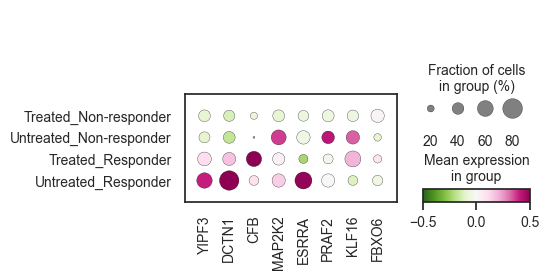

In [1377]:
sc.pl.dotplot(adata_exp_clust, res_high.index, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5)

In [1317]:
status = pd.read_csv("echidna_clone_status.csv", index_col=0)

Text(1.5, 1.5073920440182615, 'p=9.22E-1')

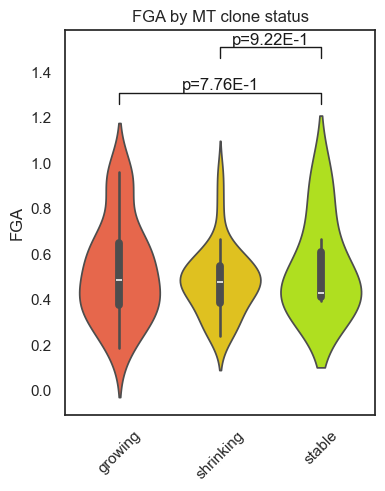

In [1358]:
data1 = list(fga.loc[0][status[status['0']=="growing"].index])
data2 = list(fga.loc[0][status[status['0']=="shrinking"].index])
data3 = list(fga.loc[0][status[status['0']=="stable"].index])

data = [data1, data2, data3]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#FF5733", "#FFD700", "#BFFF00"])

# Customizing the plot
plt.xticks(ticks=[0, 1, 2], labels=["growing","shrinking","stable"], rotation=45)
plt.ylabel("FGA")
plt.title("FGA by MT clone status")

x1, x2 = 0,2
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data1, data3)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)

x1, x2 = 1,2
y, h, col = max(map(max, data))+.5, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data2, data3)[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)

In [1368]:
stat_r = pd.DataFrame(status['0'] + cl_r.loc[status.index][0])# + cl_treat.loc[status.index][0])

Text(0.5, 1.3073920440182614, 'p=5.72E-1')

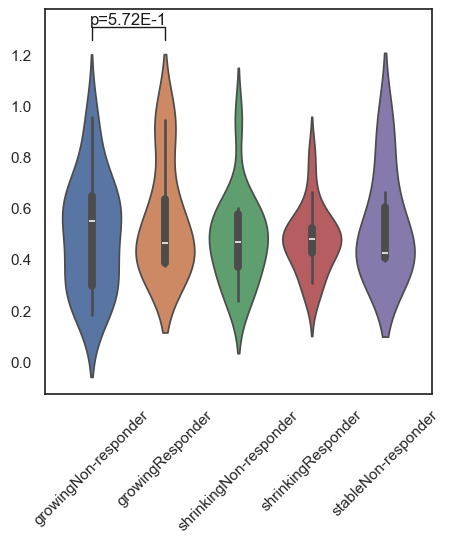

In [1370]:
data = []
labels = []
for cond in np.unique(stat_r[0]):
    data.append(list(fga.loc[0][stat_r[stat_r[0]==cond].index]))
    labels.append(cond)

plt.figure(figsize=(5, 5))
sns.violinplot(data=data)
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)

x1, x2 = 0,1
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
p = scipy.stats.mannwhitneyu(data[0], data[1])[1]
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)

# Cluster!

In [34]:
adata_exp_clust = sc.AnnData(exp_norm.T)

In [35]:
adata_exp_clust.obs["response"]=cl_r.loc[adata_exp_clust.obs_names]
adata_exp_clust.obs["treatment"]=cl_treat.loc[adata_exp_clust.obs_names]
adata_exp_clust.obs['treat_resp'] = adata_exp_clust.obs["treatment"]+"_"+adata_exp_clust.obs["response"]

In [36]:
adata_exp_clust.obs["treat_resp_gender"] = np.asarray(adata_exp_clust.obs["treat_resp"])+np.asarray(["_" for i in range(adata_exp_clust.shape[0])])+np.asarray(cl_g.loc[adata_exp_clust.obs_names][0])

In [37]:
adata_exp_clust.obs["gender"] = [i.split("_")[2] for i in adata_exp_clust.obs["treat_resp_gender"]]

In [38]:
adata_exp_clust.layers["z-score"]=scipy.stats.zscore(exp_norm.T, axis=0)

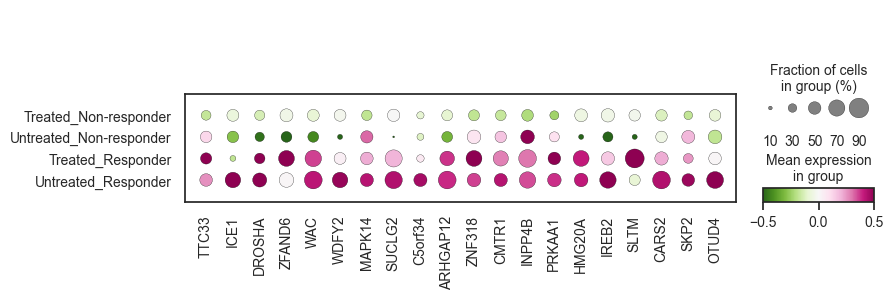

In [1400]:
sc.pl.dotplot(adata_exp_clust, high_corr_r, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], 
              vmax=.5, vmin=-.5, save="high_corr_R_dots.pdf")

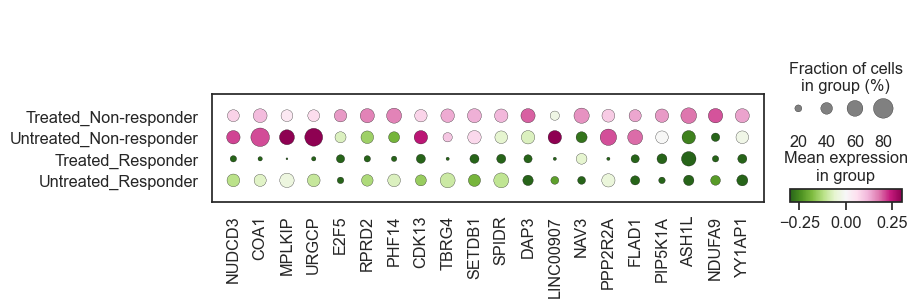

In [1457]:
sc.pl.dotplot(adata_exp_clust, high_corr_nr, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], 
              vmax=.3, vmin=-.3, save="high_corr_NR_dots.pdf")

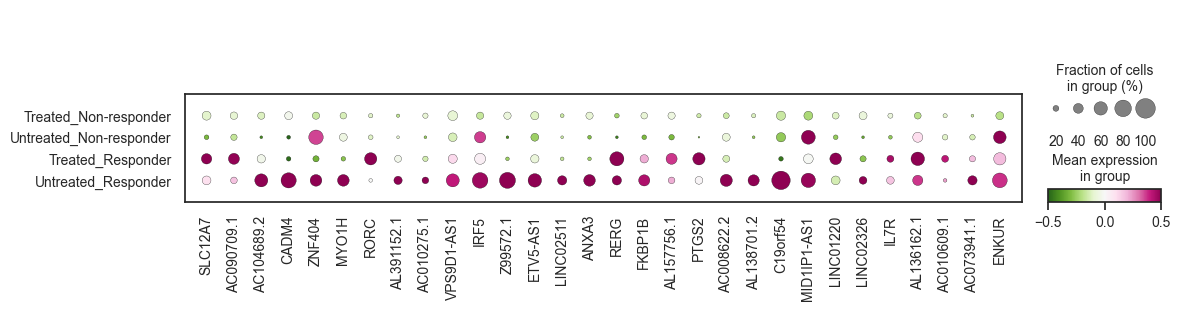

In [1402]:
sc.pl.dotplot(adata_exp_clust, low_corr_r, 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], 
              vmax=.5, vmin=-.5, save="low_corr_R_dots.pdf")

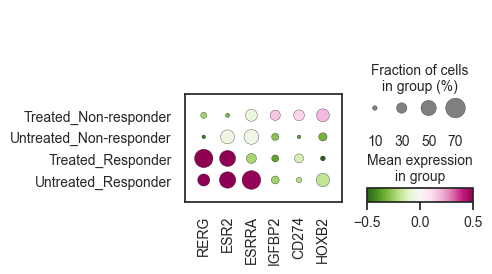

In [1404]:
sc.pl.dotplot(adata_exp_clust, ["RERG","ESR2","ESRRA","IGFBP2","CD274","HOXB2"], 
              layer='z-score', groupby='treat_resp', cmap='PiYG_r', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5, save="select_dots.pdf")

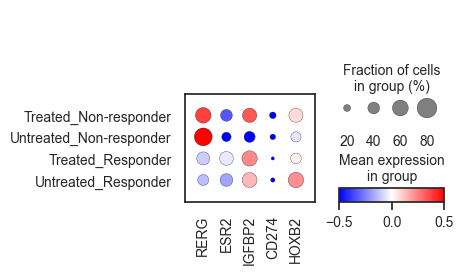

In [1405]:
sc.pl.dotplot(adata_eta, ["RERG","ESR2","IGFBP2","CD274","HOXB2"],groupby='treat_resp', cmap='bwr', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5, save="select_eta_dots.pdf")

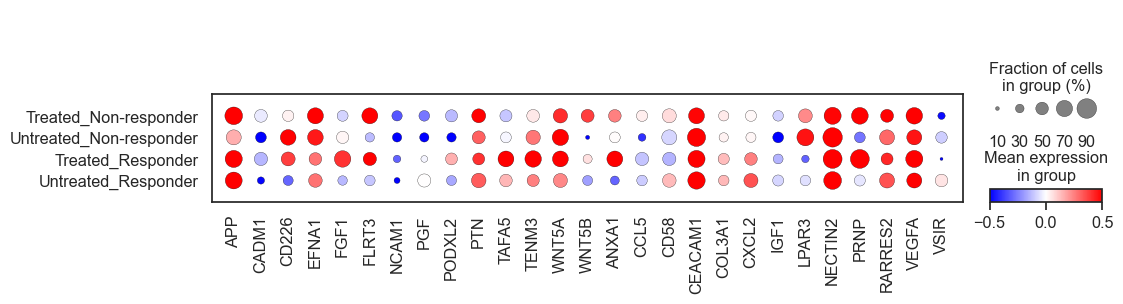

In [1471]:
sc.pl.dotplot(adata_eta, extrinsic,groupby='treat_resp', cmap='bwr', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5, save="ligand_eta_dots.pdf")

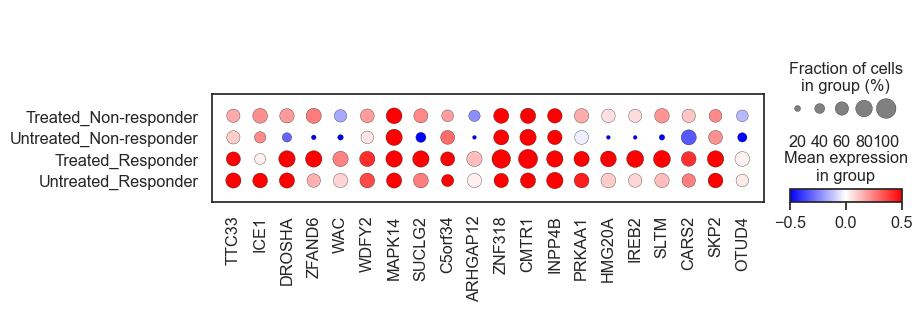

In [1472]:
sc.pl.dotplot(adata_eta, high_corr_r,groupby='treat_resp', cmap='bwr', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5, save="high_corr_R_eta_dots.pdf")

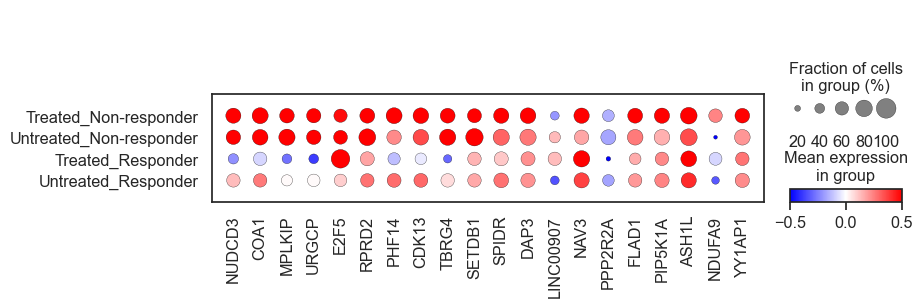

In [1473]:
sc.pl.dotplot(adata_eta, high_corr_nr,groupby='treat_resp', cmap='bwr', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], vmax=.5, vmin=-.5, save="high_corr_NR_eta_dots.pdf")

In [1176]:
obs = adata.obs
f_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="F"].index, obs[obs["responder"]=="Responder"].index)]
m_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="M"].index, obs[obs["responder"]=="Responder"].index)]
ts = []
for gene in res_nr.index:
    ts.append(scipy.stats.ttest_ind(f_df[gene], m_df[gene]))

mf_res = pd.DataFrame(ts, index=res_nr.index)
mf_res['p_value_adj'] = fdr_correction(mf_res['pvalue'], alpha=0.05)

mf_res = mf_res[mf_res["p_value_adj"]<.05]

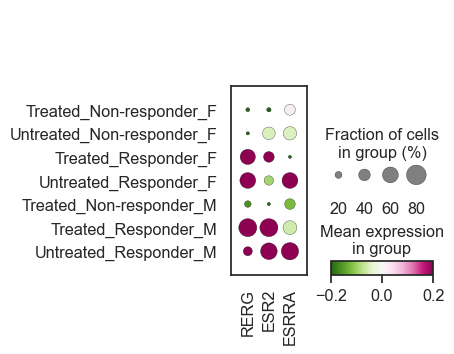

In [1480]:
genes = mf_res.sort_values(by="statistic", ascending=False).iloc[0:20].index
sc.pl.dotplot(adata_exp_clust, ["RERG","ESR2","ESRRA"], layer='z-score', groupby='treat_resp_gender', categories_order = ['Treated_Non-responder_F','Untreated_Non-responder_F',
                                                   'Treated_Responder_F',"Untreated_Responder_F", 'Treated_Non-responder_M',
                                                   'Treated_Responder_M',"Untreated_Responder_M"], cmap='PiYG_r', vmax=.2, vmin=-.2, save="MF_select_dots.pdf")

In [188]:
m = adata.to_df().loc[obs[obs["gender"]=="M"].index]
f = adata.to_df().loc[obs[obs["gender"]=="F"].index]

In [198]:
scipy.stats.wilcoxon(f["RERG"], np.random.choice(m["RERG"], f.shape[0], replace=False), alternative='greater')

WilcoxonResult(statistic=60850056.5, pvalue=0.9999998250874096)

In [199]:
scipy.stats.wilcoxon(f["ESR2"], np.random.choice(m["ESR2"], f.shape[0], replace=False), alternative='greater')

WilcoxonResult(statistic=94337792.0, pvalue=1.0)

In [200]:
scipy.stats.wilcoxon(f["ESRRA"], np.random.choice(m["ESRRA"], f.shape[0], replace=False), alternative='greater')

WilcoxonResult(statistic=167337433.0, pvalue=0.9969994352379822)

In [202]:
scipy.stats.wilcoxon(f["CD274"], np.random.choice(m["ESRRA"], f.shape[0], replace=False), alternative='greater')

WilcoxonResult(statistic=20131983.5, pvalue=1.0)

In [1465]:
"IGFBP2" in corrs[corrs['p_value_adj']>.05].index

False

In [1482]:
f_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="F"].index, obs[obs["responder"]=="Responder"].index)]
m_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="M"].index, obs[obs["responder"]=="Responder"].index)]
ts = []
for gene in res_nr.index:
    ts.append(scipy.stats.ttest_ind(f_df[gene], m_df[gene]))

mf_res = pd.DataFrame(ts, index=res_nr.index)
mf_res['p_value_adj'] = fdr_correction(mf_res['pvalue'], alpha=0.05)

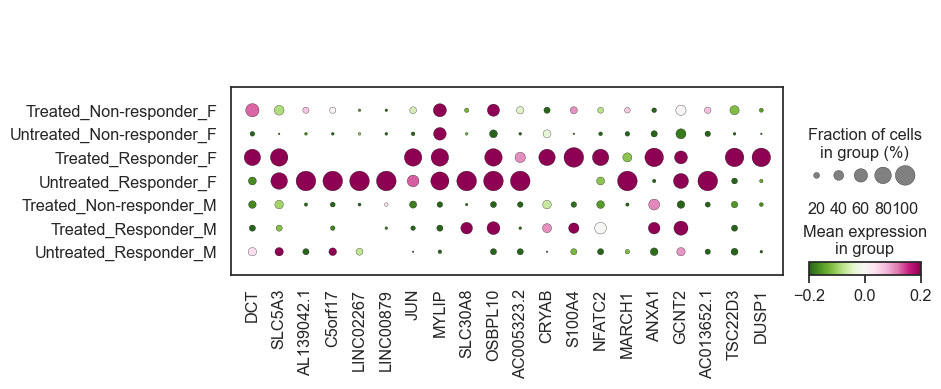

In [1483]:
genes = mf_res.sort_values(by="statistic", ascending=False).iloc[0:20].index
sc.pl.dotplot(adata_exp_clust, genes, layer='z-score', groupby='treat_resp_gender', categories_order = ['Treated_Non-responder_F','Untreated_Non-responder_F',
                                                   'Treated_Responder_F',"Untreated_Responder_F", 'Treated_Non-responder_M',
                                                   'Treated_Responder_M',"Untreated_Responder_M"], cmap='PiYG_r', vmax=.2, vmin=-.2, save="F_enrich_dots.pdf")

In [201]:
f_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="F"].index, obs[obs["responder"]=="Non-responder"].index)]
m_df = adata.to_df().loc[np.intersect1d(obs[obs["Gender"]=="M"].index, obs[obs["responder"]=="Non-responder"].index)]
ts = []
for gene in res_r.index:
    ts.append(scipy.stats.ttest_ind(f_df[gene], m_df[gene]))

mf_res = pd.DataFrame(ts, index=res_r.index)
mf_res['p_value_adj'] = fdr_correction(mf_res['pvalue'], alpha=0.05)

NameError: name 'res_r' is not defined

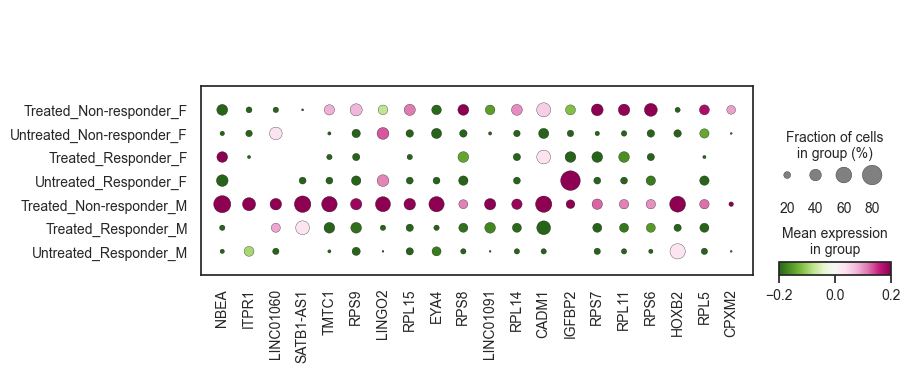

In [1408]:
genes = mf_res.sort_values(by="statistic", ascending=True).iloc[0:20].index
sc.pl.dotplot(adata_exp_clust, genes, layer='z-score', groupby='treat_resp_gender', categories_order = ['Treated_Non-responder_F','Untreated_Non-responder_F',
                                                   'Treated_Responder_F',"Untreated_Responder_F", 'Treated_Non-responder_M',
                                                   'Treated_Responder_M',"Untreated_Responder_M"], cmap='PiYG_r', vmax=.2, vmin=-.2, save="M_enrich_dots.pdf")

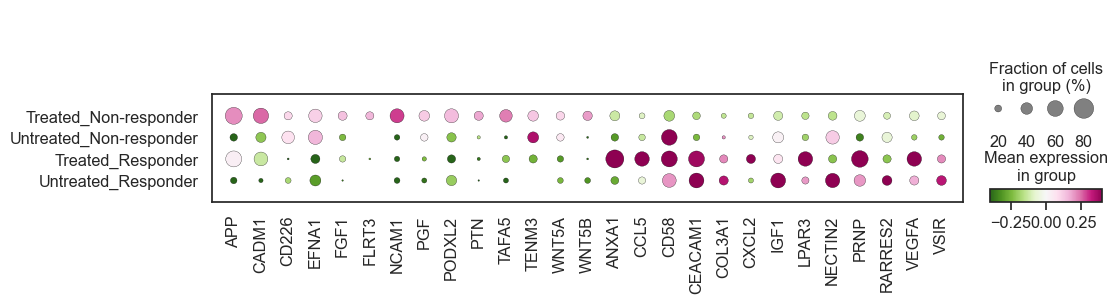

In [1451]:
sc.pl.dotplot(adata_exp_clust, extrinsic, layer='z-score', groupby='treat_resp', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], cmap='PiYG_r', vmax=.4, vmin=-.4, save="ligand_dots.pdf")

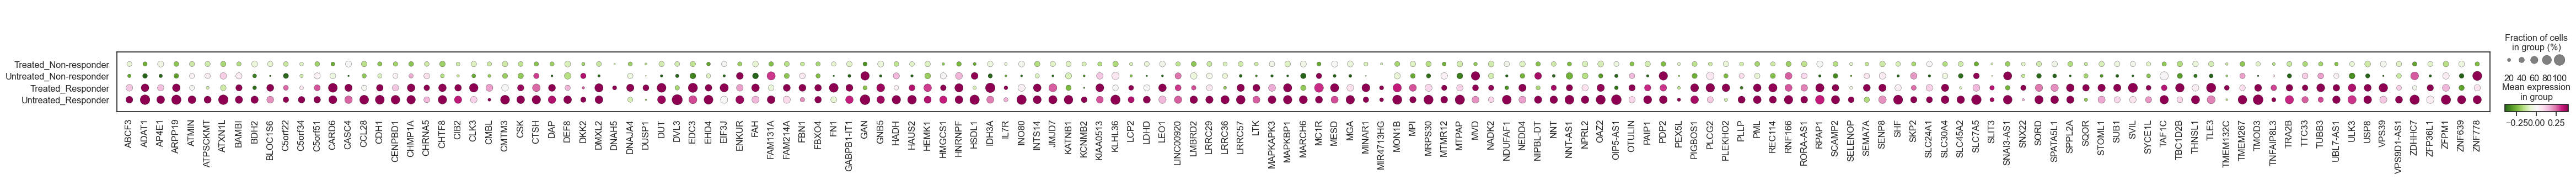

In [1450]:
sc.pl.dotplot(adata_exp_clust, intrinsic_r, layer='z-score', groupby='treat_resp', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], cmap='PiYG_r', vmax=.4, vmin=-.4, save="ligand_dots.pdf")

In [139]:
sc.tl.rank_genes_groups(sig_df, groupby='treated', method='wilcoxon')

In [140]:
treated_sigs = sc.get.rank_genes_groups_df(sig_df, group='Treated')
treated_sigs = treated_sigs[treated_sigs["pvals_adj"]<.05]
treated_sigs = treated_sigs[treated_sigs["logfoldchanges"]>0]

In [141]:
untreated_sigs = sc.get.rank_genes_groups_df(sig_df, group='Untreated')
untreated_sigs = untreated_sigs[untreated_sigs["pvals_adj"]<.05]
untreated_sigs = untreated_sigs[untreated_sigs["logfoldchanges"]>0]

In [1526]:
for i in treated_sigs["names"]:
    print(i)

XU_PRO
Wouters_Intermediate_cell_state
Anitgen_pres_pozniak
NCSC_rambow
SEMI_9PROvs2SEMI
RIESENBERG_MELANOMA_TNF_RESPONSE_GODING
tsoi_transitory
HALLMARK_ANGIOGENESIS
tsoi_neural_crest
INVASIVE_rambow
rambow_invasion
KEGG_TYPE_I_DIABETES_MELLITUS
KEGG_GRAFT_VERSUS_HOST_DISEASE
KEGG_ALLOGRAFT_REJECTION
KEGG_AUTOIMMUNE_THYROID_DISEASE
mesenchymal_vs_CAF_pozniak
ANASTASSIOU_CANCER_MESENCHYMAL_TRANSITION_SIGNATURE
rambow_neuro
Neural_Crest_like_pozniak
KEGG_CELL_ADHESION_MOLECULES_CAMS
HARRIS_HYPOXIA
KEGG_VIRAL_MYOCARDITIS
Stress_hypoxia_pozniak
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION
KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS
HALLMARK_ALLOGRAFT_REJECTION
LEE_NEURAL_CREST_STEM_CELL_UP
SEMI_4INVvs2SEMI
SARRIO_EPITHELIAL_MESENCHYMAL_TRANSITION_DN
JEFFS_INV
KEGG_PHENYLALANINE_METABOLISM
KEGG_COMPLEMENT_AND_COAGULATION_CASCADES
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
AXL_SIGNATURE_GODING
KEGG_RIBOSOME
HALLMARK_INTERFERON_GAMMA_RESPONSE
HALLMARK_COAGULATION
KEGG_TYROSINE_METABOLISM
jerby_resistance_

In [1527]:
for i in untreated_sigs["names"]:
    print(i)

KEGG_ACUTE_MYELOID_LEUKEMIA
KEGG_SNARE_INTERACTIONS_IN_VESICULAR_TRANSPORT
HALLMARK_HEME_METABOLISM
KEGG_SPHINGOLIPID_METABOLISM
tsoi_melanocytic
KEGG_RIG_I_LIKE_RECEPTOR_SIGNALING_PATHWAY
KEGG_ENDOMETRIAL_CANCER
HALLMARK_MITOTIC_SPINDLE
raj_drug_response
KAUFFMANN_DNA_REPAIR_GENES
KEGG_GLYCEROPHOSPHOLIPID_METABOLISM
KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS
KEGG_FC_EPSILON_RI_SIGNALING_PATHWAY
GO_PIGMENTATION
KEGG_RENAL_CELL_CARCINOMA
MITF_targets
KEGG_RENIN_ANGIOTENSIN_SYSTEM
HKG_Eisenberg_etal_TIG_2013
KEGG_ABC_TRANSPORTERS
KEGG_VEGF_SIGNALING_PATHWAY
SOX10_targets
KEGG_GLYCEROLIPID_METABOLISM
KEGG_TGF_BETA_SIGNALING_PATHWAY
KEGG_INOSITOL_PHOSPHATE_METABOLISM
KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS
VEER_PRO
KEGG_NUCLEOTIDE_EXCISION_REPAIR
VERF_PRO
Wouters_Melanocytic_cell_state
KEGG_BASAL_TRANSCRIPTION_FACTORS
KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION
KEGG_APOPTOSIS
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
HALLMARK_KRAS_SIGNALING_DN
KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO

In [143]:
treated_sigs[treated_sigs["names"]=="MITF_targets"]

Empty DataFrame
Columns: [names, scores, logfoldchanges, pvals, pvals_adj]
Index: []

In [151]:
responders = sig_df.to_df().loc[obs[obs["responder"]=="Responder"].index]

In [152]:
TR = responders.loc[np.intersect1d(responders.index, obs[obs["treated"]=="Treated"].index)]
UR = responders.loc[np.intersect1d(responders.index, obs[obs["treated"]=="Untreated"].index)]

In [156]:
scipy.stats.wilcoxon(TR["MITF_targets"], np.random.choice(UR["MITF_targets"], TR.shape[0], replace=False))

WilcoxonResult(statistic=100162941.5, pvalue=2.0948304705486976e-161)

In [157]:
scipy.stats.wilcoxon(TR["Tirosh_AXL_sig"], np.random.choice(UR["Tirosh_AXL_sig"], TR.shape[0], replace=False))

WilcoxonResult(statistic=44865910.0, pvalue=0.0)

In [144]:
sc.tl.rank_genes_groups(sig_df, groupby='treat_resp', method='wilcoxon')
treated_NR = sc.get.rank_genes_groups_df(sig_df, group='Treated_Non-responder')
treated_NR = treated_NR[treated_NR["pvals_adj"]<.05]
treated_NR = treated_NR[treated_NR["logfoldchanges"]>0]

In [145]:
treated_R = sc.get.rank_genes_groups_df(sig_df, group='Treated_Responder')
treated_R = treated_R[treated_R["pvals_adj"]<.05]
treated_R = treated_R[treated_R["logfoldchanges"]>0]

In [158]:
treated_NR[treated_NR["names"]=="Immune_resistance_wang"]

names     scores  logfoldchanges  pvals  pvals_adj
19  Immune_resistance_wang  38.449898         0.37835    0.0        0.0

In [164]:
treated_NR[treated_NR["names"]=="Immune_resistance_wang"]

names     scores  logfoldchanges  pvals  pvals_adj
19  Immune_resistance_wang  38.449898         0.37835    0.0        0.0

In [166]:
treated_NR.index = treated_NR["names"]
treated_NR.loc[["HALLMARK_MYC_TARGETS_V1","KEGG_OXIDATIVE_PHOSPHORYLATION"]]

names     scores  \
names                                                                       
HALLMARK_MYC_TARGETS_V1                HALLMARK_MYC_TARGETS_V1  14.860776   
KEGG_OXIDATIVE_PHOSPHORYLATION  KEGG_OXIDATIVE_PHOSPHORYLATION  11.154238   

                                logfoldchanges         pvals     pvals_adj  
names                                                                       
HALLMARK_MYC_TARGETS_V1               0.105746  5.923497e-50  8.334222e-50  
KEGG_OXIDATIVE_PHOSPHORYLATION        0.133820  6.827509e-29  8.635491e-29

In [161]:
treated_R.index = treated_R["names"]
treated_R.loc[["Anitgen_pres_pozniak","Interferon_a_b_response_pozniak","KEGG_GLYCOLYSIS_GLUCONEOGENESIS",
                                "Stress_hypoxia_pozniak","HALLMARK_APOPTOSIS","HALLMARK_IL6_JAK_STAT3_SIGNALING"]]

names     scores  \
names                                                                           
Anitgen_pres_pozniak                          Anitgen_pres_pozniak  85.972260   
Interferon_a_b_response_pozniak    Interferon_a_b_response_pozniak  75.669479   
KEGG_GLYCOLYSIS_GLUCONEOGENESIS    KEGG_GLYCOLYSIS_GLUCONEOGENESIS  39.683289   
Stress_hypoxia_pozniak                      Stress_hypoxia_pozniak  54.359425   
HALLMARK_APOPTOSIS                              HALLMARK_APOPTOSIS  97.445671   
HALLMARK_IL6_JAK_STAT3_SIGNALING  HALLMARK_IL6_JAK_STAT3_SIGNALING  76.150269   

                                  logfoldchanges  pvals  pvals_adj  
names                                                               
Anitgen_pres_pozniak                    0.777585    0.0        0.0  
Interferon_a_b_response_pozniak         0.452467    0.0        0.0  
KEGG_GLYCOLYSIS_GLUCONEOGENESIS         0.232922    0.0        0.0  
Stress_hypoxia_pozniak                  0.379360    0.0        0.0  
HALLMARK_APOPTOSIS                      0.434755    0.0        0.0  
HALLMARK_IL6_JAK_STAT3_SIGNALING        0.318080    0.0        0.0

In [69]:
sig_df.obs = adata.obs

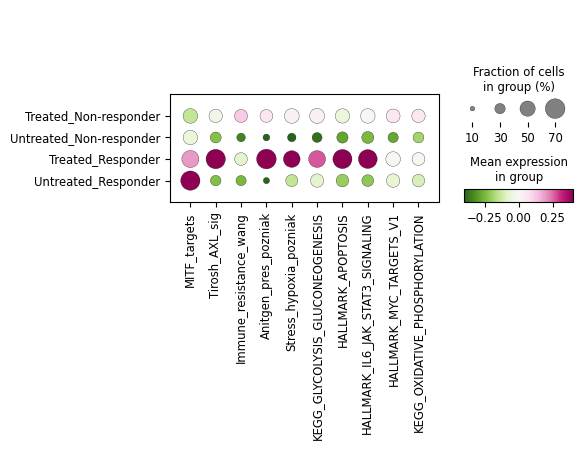

In [163]:
show = [
        "MITF_targets","Tirosh_AXL_sig","Immune_resistance_wang", "Anitgen_pres_pozniak","Stress_hypoxia_pozniak",
        "KEGG_GLYCOLYSIS_GLUCONEOGENESIS","HALLMARK_APOPTOSIS","HALLMARK_IL6_JAK_STAT3_SIGNALING","HALLMARK_MYC_TARGETS_V1","KEGG_OXIDATIVE_PHOSPHORYLATION"]
sc.pl.dotplot(sig_df, show,  layer='z-score',groupby='treat_resp', categories_order=['Treated_Non-responder','Untreated_Non-responder',
                                                                                     'Treated_Responder',"Untreated_Responder"], cmap='PiYG_r',
             vmax=.4, vmin=-.4,save="treat_untreat_sigs_dots.pdf")

In [70]:
sc.tl.rank_genes_groups(sig_df, groupby='combination', method='wilcoxon')

KeyboardInterrupt: 

In [54]:
combo = sc.get.rank_genes_groups_df(sig_df, group='treated_combination')
combo = combo[combo["pvals_adj"]<.05]
combo = combo[combo["logfoldchanges"]>0]

In [55]:
mono = sc.get.rank_genes_groups_df(sig_df, group='treated_individual')
mono = mono[mono["pvals_adj"]<.05]
mono = mono[mono["logfoldchanges"]>0]

In [1550]:
list(combo["names"][0:200])

['Wouters_Intermediate_cell_state',
 'KEGG_COMPLEMENT_AND_COAGULATION_CASCADES',
 'SEMI_4INVvs2SEMI',
 'MISHRA_CARCINOMA_ASSOCIATED_FIBROBLAST_UP',
 'HALLMARK_KRAS_SIGNALING_UP',
 'MS_RESP_TO_WOUNDING_UP_IN_MAPKi_aPDL1_NR',
 'HALLMARK_COAGULATION',
 'Wouters_Mesenchymal_like_cell_state',
 'RIESENBERG_MELANOMA_TNF_RESPONSE_GODING',
 'Neural_Crest_like_pozniak',
 'MINN_PRO',
 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
 'HALLMARK_IL2_STAT5_SIGNALING',
 'SEMI_9PROvs2SEMI',
 'XU_PRO',
 'HALLMARK_COMPLEMENT',
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
 'KEGG_FOCAL_ADHESION',
 'hugo_IPRES',
 'KEGG_ECM_RECEPTOR_INTERACTION',
 'HALLMARK_ESTROGEN_RESPONSE_EARLY',
 'HALLMARK_HYPOXIA',
 'HALLMARK_INFLAMMATORY_RESPONSE',
 'INVASIVE_rambow',
 'jerby_resistance_down',
 'HOEK_INV',
 'KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY',
 'AXL_SIGNATURE_GODING',
 'VECCHI_GASTRIC_CANCER_ADVANCED_VS_EARLY_UP',
 'NCSC_rambow',
 'rambow_invasion',
 'Tirosh_AXL_sig',
 'KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY',
 '

In [65]:
list(mono["names"][0:200])

['KEGG_RIBOSOME',
 'Immune_resistance_wang',
 'jerby_resistance_up',
 'KEGG_TYROSINE_METABOLISM',
 'Melanocytic_pozniak',
 'HYPERdiff_rambow',
 'LU_TUMOR_ENDOTHELIAL_MARKERS_UP',
 'KEGG_ALZHEIMERS_DISEASE',
 'KEGG_PHENYLALANINE_METABOLISM',
 'KEGG_OLFACTORY_TRANSDUCTION',
 'mesenchymal_vs_CAF_pozniak',
 'KEGG_PANTOTHENATE_AND_COA_BIOSYNTHESIS',
 'KEGG_HUNTINGTONS_DISEASE',
 'rambow_mitosis',
 'HALLMARK_MYC_TARGETS_V1',
 'KEGG_BETA_ALANINE_METABOLISM',
 'KEGG_CARDIAC_MUSCLE_CONTRACTION',
 'KAUFFMANN_MELANOMA_RELAPSE_UP',
 'rambow_pigmentation',
 'KEGG_NON_HOMOLOGOUS_END_JOINING',
 'KEGG_DRUG_METABOLISM_OTHER_ENZYMES',
 'KEGG_OXIDATIVE_PHOSPHORYLATION',
 'JEFFS_PRO',
 'tsoi_transitory',
 'KEGG_GAP_JUNCTION',
 'GO_REGULATION_OF_MONONUCLEAR_CELL_MIGRATION',
 'Baron_Mature_melanocytes',
 'KEGG_LONG_TERM_DEPRESSION',
 'GO_NEGATIVE_REGULATION_OF_BLOOD_VESSEL_ENDOTHELIAL_CELL_MIGRATION',
 'HALLMARK_E2F_TARGETS',
 'KEGG_PARKINSONS_DISEASE',
 'cheng_mitotic_top100',
 'CIN70',
 'KEGG_MELANOGENESI

In [56]:
show = ["HALLMARK_IL6_JAK_STAT3_SIGNALING","Tirosh_AXL_sig","HALLMARK_TGF_BETA_SIGNALING","HALLMARK_APOPTOSIS","HALLMARK_TNFA_SIGNALING_VIA_NFKB",
 "HALLMARK_IL2_STAT5_SIGNALING","HALLMARK_COMPLEMENT","HALLMARK_HYPOXIA","HALLMARK_INFLAMMATORY_RESPONSE","Interferon_a_b_response_pozniak","Immune_resistance_wang",
 "HALLMARK_MYC_TARGETS_V1","KAUFFMANN_MELANOMA_RELAPSE_UP","CIN70","Tirosh_MITF_sig"]

In [64]:
sig_df.obs["combination"] = adata.obs["combination"] 

NameError: name 'sig_df' is not defined

In [70]:
tmp = []
for i in sig_df.obs["combination"]:
    if pd.isna(i):
        tmp.append("NaN")
    else:
        tmp.append(i)

In [71]:
sig_df.obs["combination"] = tmp

In [72]:
obs = sig_df.obs

In [73]:
sig_df.obs['resp_combo'] = np.asarray(obs["responder"])+"_"+np.asarray([str(i) for i in obs["combination"]])

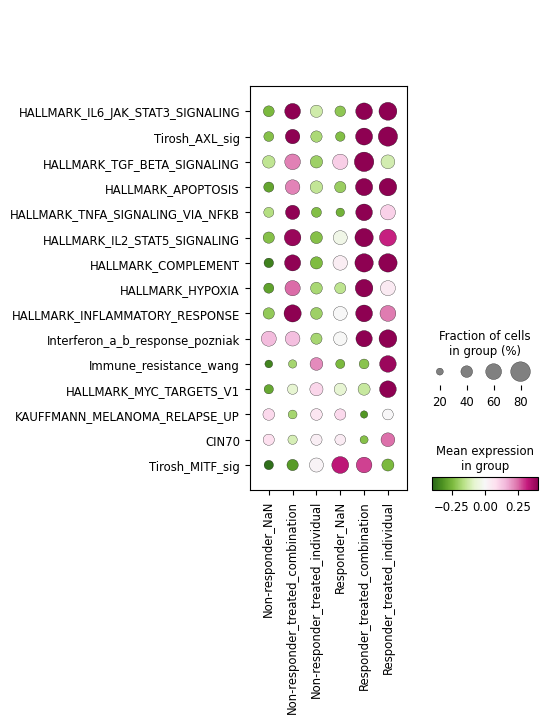

In [75]:
sc.pl.dotplot(sig_df, show,  layer='z-score',groupby='resp_combo', cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True, save="combo_mono_dots.pdf")

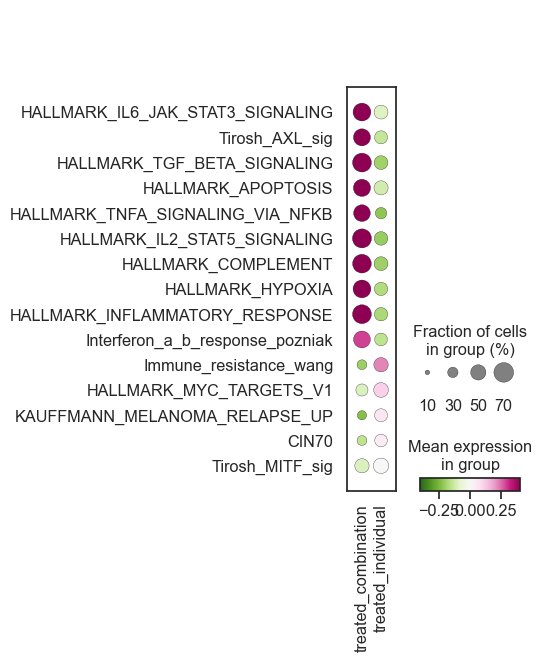

In [1558]:
sc.pl.dotplot(sig_df, show,  layer='z-score',groupby='combination', cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True)

In [1566]:
obs = adata.obs
treated_adata = adata[obs[obs["treated"]=="Treated"].index]

In [1567]:
sc.tl.rank_genes_groups(treated_adata, groupby='gender', method='wilcoxon')

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [1568]:
F = sc.get.rank_genes_groups_df(treated_adata, group='F')
F = F[F["pvals_adj"]<.05]
F = F[F["logfoldchanges"]>0]

In [1569]:
F.index = F["names"]
np.intersect1d(F.index,["FIRRE","GYG2","XIST","MX1","MX2","IRF4","IRF9","JAK1","JAK2","STAT1","STAT6","IL10"])

array(['FIRRE', 'MX1', 'MX2', 'STAT1', 'STAT6'], dtype=object)

In [1570]:
M = sc.get.rank_genes_groups_df(adata, group='M')
M = M[M["pvals_adj"]<.05]
M = M[M["logfoldchanges"]>0]

In [1571]:
M.index = M["names"]
np.intersect1d(M.index,["UTY","DDX3Y","KDM5D","VGF","TCF4","HLA-DRA","HLA-DRB1"])

array(['HLA-DRA', 'HLA-DRB1'], dtype=object)

In [78]:
adata_exp_clust.obs['resp_gender'] = np.asarray(adata_exp_clust.obs["response"])+"_"+np.asarray(adata_exp_clust.obs["gender"])

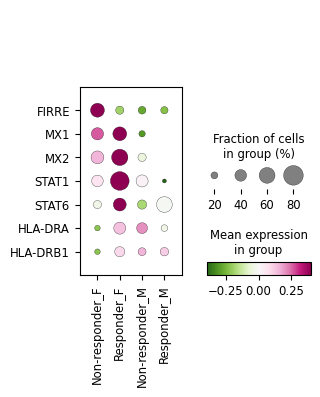

In [79]:
sc.pl.dotplot(adata_exp_clust, ['FIRRE', 'MX1', 'MX2', 'STAT1', 'STAT6','HLA-DRA', 'HLA-DRB1'],layer='z-score',groupby='resp_gender', 
              categories_order=["Non-responder_F","Responder_F","Non-responder_M","Responder_M"],cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True,save="mf_dots.pdf")

In [170]:
adata_exp_clust.obs['treat_gender'] = np.asarray(adata_exp_clust.obs["treatment"])+"_"+np.asarray(adata_exp_clust.obs["gender"])

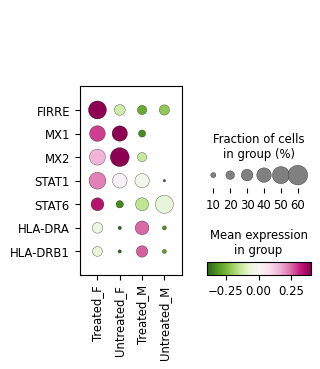

In [174]:
sc.pl.dotplot(adata_exp_clust, ['FIRRE', 'MX1', 'MX2', 'STAT1', 'STAT6','HLA-DRA', 'HLA-DRB1'],layer='z-score',groupby='treat_gender', 
             categories_order=["Treated_F","Untreated_F","Treated_M","Untreated_M"],cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True,save="mf_dots.pdf")

In [39]:
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["mucosal"])[0])

adata.obs["mucosal"] = add

In [ ]:
obs = adata.obs
treated_adata = adata[obs[obs["treated"]=="Treated"].index]

sc.tl.rank_genes_groups(treated_adata, groupby='mucosal', method='wilcoxon')

muc = sc.get.rank_genes_groups_df(treated_adata, group='Mucosal')
muc = muc[muc["pvals_adj"]<.05]
muc = muc[muc["logfoldchanges"]>0]

In [1587]:
np.intersect1d(muc["names"],["PTCH2","SMO","GLI2","GLI3","EMP1","TIAM1","NCAM2","SNAI2","SDK1","SOX4","STAT3","BLC2"])

array(['EMP1', 'GLI2', 'GLI3', 'NCAM2', 'SDK1', 'SMO', 'SNAI2', 'SOX4',
       'TIAM1'], dtype=object)

In [1588]:
nmuc = sc.get.rank_genes_groups_df(treated_adata, group='Non-mucosal')
nmuc = nmuc[nmuc["pvals_adj"]<.05]
nmuc = nmuc[nmuc["logfoldchanges"]>0]

In [1590]:
np.intersect1d(nmuc["names"],["MITF","COX8A","COX4I1","ATP5F1E","CCL21","B2M","CTSB","HLA-A","HLA-B","HLA-C"])

array(['B2M', 'COX4I1', 'CTSB', 'HLA-A', 'HLA-B', 'HLA-C'], dtype=object)

In [40]:
clin = pd.read_csv('clin.csv')
clin.index = clin["sample"]
clin = clin.drop_duplicates()

import os
PATH = "hmm_all_pt/"
cl_muc = pd.DataFrame()
for patient in os.listdir(PATH):
    if "_" not in patient:
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_muc[patient+"_"+str(cl)] = [clin.loc[sampl]["mucosal"]]

PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        X = sc.read_h5ad(PATH+patient+"/X.h5ad")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_muc[patient+"_"+str(cl)] = [clin.loc[sampl]["mucosal"]]
cl_muc = cl_muc.T

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2096020511.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_muc[patient+"_"+str(cl)] = [clin.loc[sampl]["mucosal"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2096020511.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_muc[patient+"_"+str(cl)] = [clin.loc[sampl]["mucosal"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/2096020511.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [41]:
adata_exp_clust.obs["mucosal"]=cl_muc.loc[adata_exp_clust.obs_names]

In [42]:
adata_exp_clust.obs['treat_mucosal'] = np.asarray(adata_exp_clust.obs["treatment"])+"_"+np.asarray(adata_exp_clust.obs["mucosal"])

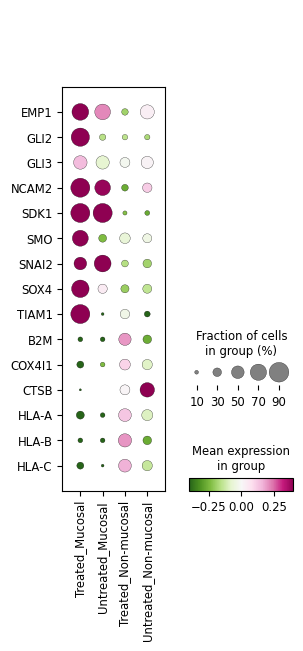

In [83]:
sc.pl.dotplot(adata_exp_clust, ['EMP1', 'GLI2', 'GLI3', 'NCAM2', 'SDK1', 'SMO', 'SNAI2', 'SOX4',
       'TIAM1','B2M', 'COX4I1', 'CTSB', 'HLA-A', 'HLA-B', 'HLA-C'],layer='z-score',groupby='treat_mucosal',
              categories_order=["Treated_Mucosal","Untreated_Mucosal","Treated_Non-mucosal","Untreated_Non-mucosal"],cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True,save="muc_dots.pdf")

In [210]:
sig_df.obs = adata.obs
treated_sigs = sig_df[obs[obs["treated"]=="Treated"].index]
sc.tl.rank_genes_groups(treated_sigs, groupby='mucosal', method='wilcoxon')

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [211]:
muc = sc.get.rank_genes_groups_df(treated_sigs, group='Mucosal')
muc = muc[muc["pvals_adj"]<.05]
muc = muc[muc["logfoldchanges"]>0]

In [214]:
np.intersect1d(["HALLMARK_KRAS_SIGNALING_DN","KEGG_HEDGEHOG_SIGNALING_PATHWAY","KEGG_DORSO_VENTRAL_AXIS_FORMATION"],muc["names"])

PH_BLOOD_VESS_DEVEL_DN_IN_R
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION
KEGG_GLYCOSAMINOGLYCAN_BIOSYNTHESIS_HEPARAN_SULFATE
GO_POSITIVE_REGULATION_OF_BLOOD_VESSEL_ENDOTHELIAL_CELL_MIGRATION
MAHADEVAN_GIST_MORPHOLOGICAL_SWITCH
KEGG_NON_HOMOLOGOUS_END_JOINING
tsoi_undifferentiated
WESTON_VEGFA_TARGETS_12HR
MAPKi_INDUCED_EMT
rambow_invasion
WESTON_VEGFA_TARGETS_6HR
INVASIVE_rambow
LU_TUMOR_ANGIOGENESIS_UP
VERF_INV
AP1_targets
TEAD_targets
GO_POSITIVE_REGULATION_OF_FIBROBLAST_MIGRATION
VEER_PRO
HALLMARK_ANGIOGENESIS
SMC_rambow
KEGG_PRIMARY_BILE_ACID_BIOSYNTHESIS
MAPKi_INDUCED_ANGIOGENESIS
VECCHI_GASTRIC_CANCER_ADVANCED_VS_EARLY_UP
LEF1_UP.V1_UP
LEE_NEURAL_CREST_STEM_CELL_UP
KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS
HALLMARK_KRAS_SIGNALING_DN
ANASTASSIOU_CANCER_MESENCHYMAL_TRANSITION_SIGNATURE
KAUFFMANN_MELANOMA_RELAPSE_UP
LU_TUMOR_ENDOTHELIAL_MARKERS_UP
KEGG_DNA_REPLICATION
KEGG_GLYCEROLIPID_METABOLISM
cheng_mesench_top100
HALLMARK_E2F_TARGETS
Mesenchymal_like_pozniak
KEGG_GLYCOSAMINOGLYCAN_B

In [215]:
nmuc = sc.get.rank_genes_groups_df(treated_sigs, group='Non-mucosal')
nmuc = nmuc[nmuc["pvals_adj"]<.05]
nmuc = nmuc[nmuc["logfoldchanges"]>0]

In [223]:
for i in nmuc["names"]:
    print(i)

KEGG_LYSOSOME
jerby_resistance_down
KEGG_HEMATOPOIETIC_CELL_LINEAGE
HALLMARK_KRAS_SIGNALING_UP
HALLMARK_PROTEIN_SECRETION
KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION
HALLMARK_COMPLEMENT
KEGG_ALZHEIMERS_DISEASE
HALLMARK_HEME_METABOLISM
HALLMARK_COAGULATION
NCSC_rambow
rambow_neuro
KEGG_PROXIMAL_TUBULE_BICARBONATE_RECLAMATION
KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION
KEGG_INSULIN_SIGNALING_PATHWAY
KEGG_APOPTOSIS
Interferon_a_b_response_pozniak
KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_LACTO_AND_NEOLACTO_SERIES
HALLMARK_CHOLESTEROL_HOMEOSTASIS
HKG_Chang_etal_PlosOne_2011
KEGG_LONG_TERM_POTENTIATION
SEMI_4INVvs2SEMI
KEGG_NATURAL_KILLER_CELL_MEDIATED_CYTOTOXICITY
KEGG_LONG_TERM_DEPRESSION
HKG_Eisenberg_etal_TIG_2013
HALLMARK_HEDGEHOG_SIGNALING
KEGG_PROSTATE_CANCER
KEGG_OOCYTE_MEIOSIS
KEGG_COMPLEMENT_AND_COAGULATION_CASCADES
HALLMARK_PI3K_AKT_MTOR_SIGNALING
HALLMARK_ANDROGEN_RESPONSE
KEGG_JAK_STAT_SIGNALING_PATHWAY
Neural_Crest_like_pozniak
KEGG_TYPE_I_DIABETES_MELLITUS
Baron_Neural_crest
KE

In [220]:
obs = treated_sigs.obs
treated_sigs.obs['treated_mucosal'] = np.asarray(obs["treated"])+"_"+np.asarray([str(i) for i in obs["mucosal"]])

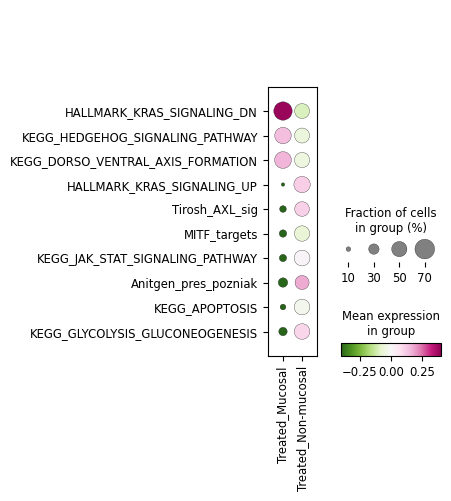

In [225]:
sc.pl.dotplot(treated_sigs, ["HALLMARK_KRAS_SIGNALING_DN","KEGG_HEDGEHOG_SIGNALING_PATHWAY",
                             "KEGG_DORSO_VENTRAL_AXIS_FORMATION","HALLMARK_KRAS_SIGNALING_UP","Tirosh_AXL_sig","MITF_targets",
                            "KEGG_JAK_STAT_SIGNALING_PATHWAY","Anitgen_pres_pozniak","KEGG_APOPTOSIS","KEGG_GLYCOLYSIS_GLUCONEOGENESIS"],  layer='z-score',
              groupby='treated_mucosal', cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True, save='mucosal_sigs.pdf')

In [97]:
obs = adata.obs
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["genotype_simplified"])[0])

adata.obs["genotype"] = add

In [99]:
sc.tl.rank_genes_groups(adata, groupby='genotype', method='wilcoxon')

In [130]:
braf = sc.get.rank_genes_groups_df(adata, group='BRAF mut')
braf = braf[braf["pvals_adj"]<.05]
braf = braf[braf["logfoldchanges"]>0]

In [104]:
nras = sc.get.rank_genes_groups_df(adata, group='NRAS mut')
nras = nras[nras["pvals_adj"]<.05]
nras = nras[nras["logfoldchanges"]>0]

In tumor cells of BRAFmut samples, we see an upregulation of BRAF and components of the insulin-like growth factor (IGF) signaling pathway (e.g., IGF2, IGFBP5) (Figure 4I) as the activation of the MAPK pathway can promote the expression of IGF2 and thereby enhance tumor growth. We can recover the expected increase of melanocytic lineage genes (e.g., MITF, IL24) in tumor cells of BRAFmut (Figures 4I-J). In addition, we find upregulation of genes associated with EMT and angiogenesis programs (e.g., COL4A2, FN1, ANGPT1) (Figures 4I-K). In contrast, tumor cells of NRASmut samples show upregulated expression of NRAS, interferon signaling and immune modulation (e.g., IFNGR1/2, IL16), and oxidative phosphorylation (e.g., ATP5MC2) (Figures 4I-K).

In [128]:
braf = sc.get.rank_genes_groups_df(adata, group='BRAF mut')

In [129]:
braf.index = braf["names"]
braf.loc["MAPK14"]

names               MAPK14
scores            16.24991
logfoldchanges    0.145103
pvals                  0.0
pvals_adj              0.0
Name: MAPK14, dtype: object

In [105]:
np.intersect1d(braf["names"],["IGF2","IGFBP5","MITF","IL24","COL4A2","FN1","ANGPT1"])

array(['ANGPT1', 'COL4A2', 'FN1', 'IGFBP5', 'MITF'], dtype=object)

In [177]:
np.intersect1d(nras["names"],["IFNGR1","IFNGR2","IL16","ATP5MC2","NRAS"])

array(['ATP5MC2', 'IFNGR1', 'IFNGR2', 'IL16', 'NRAS'], dtype=object)

In [133]:
"MAPK14" in list(braf["names"])

True

In [175]:
np.intersect1d(braf["names"],["BRAF"])

array(['BRAF'], dtype=object)

In [94]:
clin = pd.read_csv('clin.csv')
clin.index = clin["sample"]
clin = clin.drop_duplicates()

import os
PATH = "hmm_all_pt/"
cl_geno = pd.DataFrame()
for patient in os.listdir(PATH):
    if "_" not in patient:
        X = sc.read_h5ad(PATH+patient+"/"+patient+"_X.h5")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_geno[patient+"_"+str(cl)] = [clin.loc[sampl]["genotype_simplified"]]

PATH = "ST_results/"
for patient in os.listdir(PATH):
    if "DS" not in patient and patient.split("_")[0] not in mt_patients:
        X = sc.read_h5ad(PATH+patient+"/X.h5ad")
        obs = X.obs
        for cl in np.unique(obs["leiden"]):
            sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["sample"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
            cl_geno[patient+"_"+str(cl)] = [clin.loc[sampl]["genotype_simplified"]]
cl_geno = cl_geno.T

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/2455786508.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_geno[patient+"_"+str(cl)] = [clin.loc[sampl]["genotype_simplified"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/2455786508.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cl_geno[patient+"_"+str(cl)] = [clin.loc[sampl]["genotype_simplified"]]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_16938/2455786508.py:23: PerformanceWarning: DataFrame is highly fragmente

In [113]:
adata_exp_clust.obs["genotype"]=np.asarray(pd.DataFrame(cl_geno.loc[adata_exp_clust.obs_names]).fillna("NaN")[0])

In [114]:
adata_exp_clust.obs['resp_mut'] = np.asarray(adata_exp_clust.obs["response"])+"_"+np.asarray(adata_exp_clust.obs["genotype"])

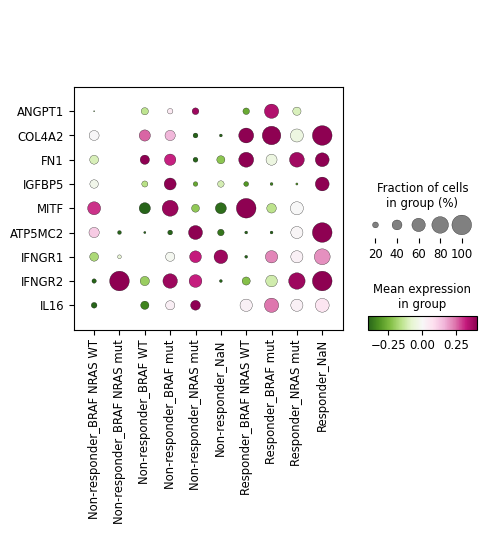

In [118]:
sc.pl.dotplot(adata_exp_clust, ['ANGPT1', 'COL4A2', 'FN1', 'IGFBP5', 'MITF','ATP5MC2', 'IFNGR1', 'IFNGR2', 'IL16'],layer='z-score',groupby='resp_mut'
              ,cmap='PiYG_r', 
             vmax=.4, vmin=-.4, swap_axes=True)

In [119]:
np.unique(adata_exp_clust.obs["resp_mut"])

array(['Non-responder_BRAF NRAS WT', 'Non-responder_BRAF NRAS mut',
       'Non-responder_BRAF WT', 'Non-responder_BRAF mut',
       'Non-responder_NRAS mut', 'Non-responder_NaN',
       'Responder_BRAF NRAS WT', 'Responder_BRAF mut',
       'Responder_NRAS mut', 'Responder_NaN'], dtype=object)

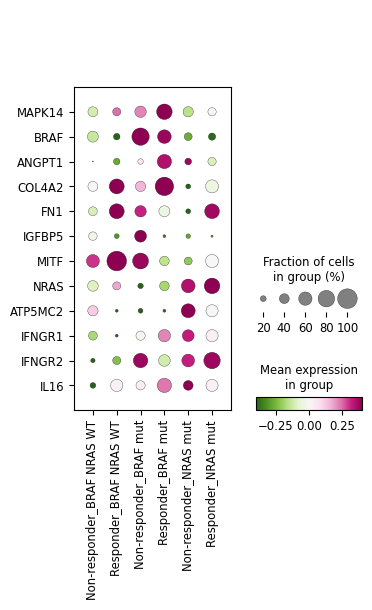

In [178]:
groups_to_keep = ["Non-responder_BRAF NRAS WT", "Responder_BRAF NRAS WT",'Non-responder_BRAF mut','Responder_BRAF mut',
                 'Non-responder_NRAS mut','Responder_NRAS mut']
adata_subset = adata_exp_clust[adata_exp_clust.obs["resp_mut"].isin(groups_to_keep)].copy()

# Now plot only those groups
sc.pl.dotplot(
    adata_subset,
    var_names=['MAPK14','BRAF','ANGPT1', 'COL4A2', 'FN1', 'IGFBP5', 'MITF','NRAS','ATP5MC2', 'IFNGR1', 'IFNGR2', 'IL16'],layer='z-score',groupby='resp_mut'
              ,cmap='PiYG_r', categories_order=groups_to_keep,
             vmax=.4, vmin=-.4, swap_axes=True,save="genotype.pdf")

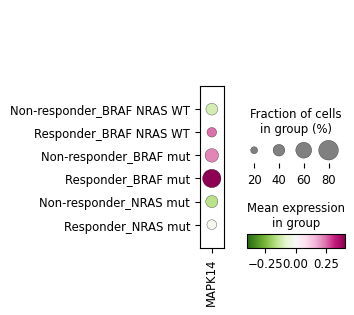

In [126]:
sc.pl.dotplot(
    adata_subset,
    var_names=['MAPK14'],layer='z-score',groupby='resp_mut'
              ,cmap='PiYG_r', categories_order=groups_to_keep,
             vmax=.4, vmin=-.4)

In [47]:
clin["cohort"]

Index(['sample', 'patient', 'samples_per_patient', 'time',
       'Before.During.After', 'Sample_J', 'days_since_ICI_start',
       'treatment_duration', 'Tx_start_days', 'treatment_drug', 'Gender',
       'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'genotype_simplified',
       'sample_group', 'group_outcome', 'group', 'time_drug', 'pair', 'pair2',
       'best_response', 'survival_status', 'PFS', 'OS', 'treated', 'responder',
       'mucosal', 'Tx_phase', 'cohort', 'combination', 'treat_resp'],
      dtype='object')

In [50]:
obs = adata.obs
add = []
for i in adata.obs_names:
    add.append(list(clin[clin["sample"]==obs.loc[i]["sample"]]["treatment_drug"])[0])

adata.obs["treatment_drug"] = add

In [71]:
sig_df.obs = adata.obs

In [90]:
obs = sig_df.obs
individual_sigs = sig_df[obs[obs["combination"]=="treated_individual"].index]

In [92]:
obs = individual_sigs.obs
individual_sigs = individual_sigs[obs[obs["responder"]=="Non-responder"].index]

In [94]:
pd_ct = []
for i in individual_sigs.obs["treatment_drug"]:
    if "ipilimumab" in i:
        pd_ct.append("anti_CTLA4")
    elif "pembro" in i:
        pd_ct.append("anti_PD1")
    elif "sparta" in i:
        pd_ct.append("anti_PD1")
    else:
        pd_ct.append("neither")
individual_sigs.obs["pd_ct"]=pd_ct

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_10041/1497285290.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  individual_sigs.obs["pd_ct"]=pd_ct


In [118]:
obs = individual_sigs.obs
individual_sigs = individual_sigs[obs[obs["pd_ct"]!="neither"].index]

In [119]:
sc.tl.rank_genes_groups(individual_sigs, groupby='pd_ct', method='wilcoxon')

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [120]:
pd = sc.get.rank_genes_groups_df(individual_sigs, group='anti_PD1')
pd = pd[pd["pvals_adj"]<.05]
pd = pd[pd["logfoldchanges"]>0]

In [128]:
for i in list(pd.names):
    if "JAK" in i:
        print(i)
    if "Interferon" in i:
        print(i)

KEGG_JAK_STAT_SIGNALING_PATHWAY
Interferon_a_b_response_pozniak
HALLMARK_IL6_JAK_STAT3_SIGNALING


In [122]:
ctla = sc.get.rank_genes_groups_df(individual_sigs, group='anti_CTLA4')
ctla = ctla[ctla["pvals_adj"]<.05]
ctla = ctla[ctla["logfoldchanges"]>0]

In [113]:
neither = sc.get.rank_genes_groups_df(individual_sigs, group='neither')
neither = neither[neither["pvals_adj"]<.05]
neither = neither[neither["logfoldchanges"]>0]

In [123]:
for i in list(ctla.names):
    if "JAK" in i:
        print(i)
    if "MHC" in i:
        print(i)

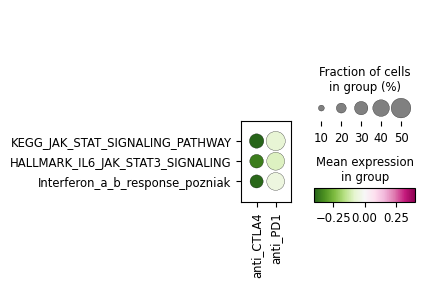

In [132]:
show = ["KEGG_JAK_STAT_SIGNALING_PATHWAY","HALLMARK_IL6_JAK_STAT3_SIGNALING","Interferon_a_b_response_pozniak"]
sc.pl.dotplot(individual_sigs, show,  layer='z-score',groupby='pd_ct', cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True, save="pd1_ctla.pdf")

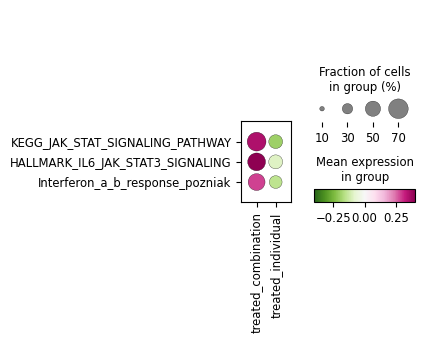

In [133]:
sc.pl.dotplot(sig_df, show,  layer='z-score',groupby='combination', cmap='PiYG_r',
             vmax=.4, vmin=-.4, swap_axes=True, save="combo_mono_8h.pdf")

In [135]:
import pandas as pd
kinomo = pd.read_csv("table_finalgenes_best_top100_ward.D2_7MPs.csv")

In [142]:
mp1 = np.intersect1d(adata.var_names, list(kinomo["MP1"].dropna()))

Text(0.5, 1.2607275605201722, 'p=7.12E-2')

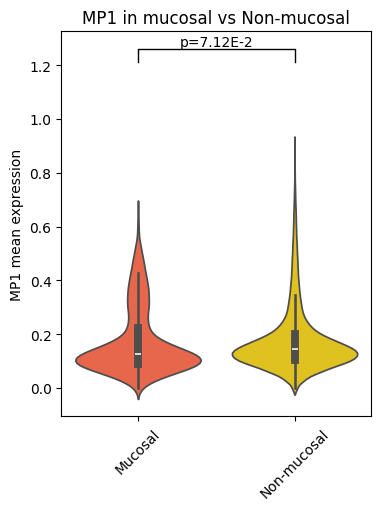

In [154]:


data1 = list(adata[obs[obs["mucosal"]=="Mucosal"].index].to_df()[mp1].mean(axis=1))
data2 = list(adata[obs[obs["mucosal"]=="Non-mucosal"].index].to_df()[mp1].mean(axis=1))

data = [data1, data2]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#FF5733", "#FFD700"])

# Customizing the plot
plt.xticks(ticks=[0, 1], labels=["Mucosal","Non-mucosal"], rotation=45)
plt.ylabel("MP1 mean expression")
plt.title("MP1 in mucosal vs Non-mucosal")

x1, x2 = 0,1
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
t, p = scipy.stats.ttest_ind(data1, data2)
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)


Text(0.5, 0.5571324735879899, 'p=2.07E-1')

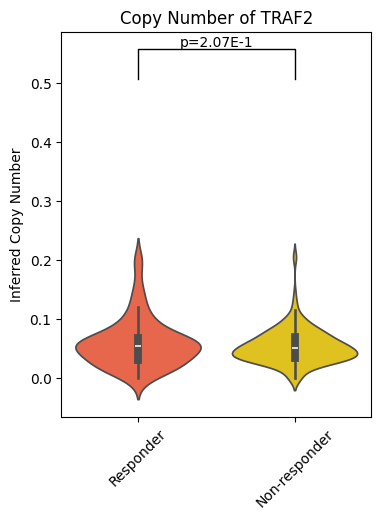

In [174]:
data1 = list(exp_norm[cl_r[cl_r[0]=="Responder"].index].loc["TRAF2"])
data2 = list(exp_norm[cl_r[cl_r[0]=="Non-responder"].index].loc["TRAF2"])

data = [data1, data2]


# Creating the violin plot
plt.figure(figsize=(4, 5))
sns.violinplot(data=data, palette=["#FF5733", "#FFD700"])

# Customizing the plot
plt.xticks(ticks=[0, 1], labels=["Responder","Non-responder"], rotation=45)
plt.ylabel("Inferred Copy Number")
plt.title("Copy Number of TRAF2")

x1, x2 = 0,1
y, h, col = max(map(max, data))+.3, .05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
t, p = scipy.stats.ttest_ind(data1, data2)
p = "{:.2E}".format(Decimal(p))
plt.text((x1+x2)*.5, y+h, "p="+str(p), ha='center', va='bottom', color=col)
